# **************** DRAFT *** DRAFT *** DRAFT ************

# Largest Glaciers in the World

This jupyter notebook provides an analysis the largest glaciers in the world using the Global Land Ice Measurements from Space (GLIMS) glacier outline database and the Randolph Glaicer Inventory (RGI) glacier outline database. The Global Terrestrial Network for Glaciers (GTN-G) has defined 19 glacier regions worldwide. The largest 3 glaciers in each of the 19 regions is examined here. 

### Background and Motivation

Glaciers are retreating at an alarming rate. Montana’s Glacier National Park had 150 glaciers in 1850; today only 25 remain and they are shrinking. Muir glacier in Alaska has retreated 31 miles since 1892 and is now only a fraction of its former grandeur measuring at only 11 miles long, today. 

Not only are glaciers a beautiful part of our landscape that are disappearing but in many parts of the world glaciers are a source of fresh water and energy through the use of the melt water. As these glaciers retreat, these nations will be out of water or need to find alternative forms of energy. Studying glaciers helps to inform our knowledge of climate change and helps water and energy resource managers plan for the future. Researchers have performed many regional studies of glaciers; however, global studies are scarce. Therefore, I am doing a global assessment of glaciers and glacial retreat to further our knowledge of these important natural resources on a worldwide scale. The outcome of the project will be an education and outreach blog post to help to inform people of the changes occurring in glaciers across the globe.

I'm doing this project in conjunction with the [World Glacier Monitoring Service](https://wgms.ch/) located at the University of Zurich. The WGMS compiles and disseminates standardized data on glacier fluctuations.

### Data Used

* GLIMS: http://www.glims.org/download/glims_db_20190304.tgz
  * GLIMS (Global Land Ice Measurements from Space) is a project designed to monitor the world's glaciers primarily using data from optical satellite instruments. It provides glacial outlines at multi-temporal resolution for glaciers around the world as shapefiles.
* RGI: https://www.glims.org/RGI/rgi60_dl.html
  * The Randolph Glacier Inventory (RGI) is a globally complete inventory of glacier outlines. Production of the RGI was motivated by the preparation of the Fifth Assessment Report of the Intergovernmental Panel on Climate Change. It provides glacial outlines for glaciers around the world as shapefiles. The RGI is intended to be a snapshot of the world’s glaciers as they were near the beginning of the 21st century.
* GTN-G Regions: http://www.gtn-g.ch/database/GlacReg_2017.zip
  * Glacier regions are useful for regional assessments of glacier change and other parameters. This dataset, provided by the Global Terrestrial Network for Glaciers (GTN-G), defines 19 first-order glacier regions. The GTN-G is the framework for the internationally coordinated monitoring of glaciers and ice caps in support of the United Nations Framework Convention on Climate Change (UNFCCC).
  
### Methods
Several definitions of glacial terms must be defined to accurately assess the largest glaciers in the world. There can be differing definitions of these items. For this analysis, I use the following defnitions:

* glacier: 
* outlet glacier:
* ice cap:
* icefiled:
* ice sheet:
* ice mass:

Because different science disciplines, institutions, and even countries have different definitions for the above terms, I have expanded the analysis to also include the largest ice caps and then the largest outlent glaciers on these ice caps to provide as broad an overview of the largest ice masses in the world.

To help in determining names of glaciers and resolving differences in the GLIMS and RGI databases, I used the Fluctuations of Glaciers (FoG) glacier browser (https://www.wgms.ch/fogbrowser/), GLIMS glacier viewer (https://www.glims.org/maps/glims), and Mapcarta (https://mapcarta.com/).

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
from shapely.geometry import polygon
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import plotting_extent
import earthpy.spatial as es
import warnings
warnings.filterwarnings("ignore")

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

## The 19 Glacier Regions

The GTN-G has defined 19 glacier regions worldwide. A list of these regions plus a map is shown below.

In [2]:
# Open glacier region shapefile and display regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)
glacier_regions.rename(columns = {'FULL_NAME': 'Region Name', 'RGI_CODE': 'Region Number'}, inplace=True)
print('List of the 19 glacier regions:')
print('')
print(glacier_regions[['Region Number', 'Region Name']].to_string(index=False))

List of the 19 glacier regions:

 Region Number                 Region Name
             1                      Alaska
             2      Western Canada and USA
             3        Arctic Canada, North
             4        Arctic Canada, South
             5         Greenland Periphery
             6                     Iceland
             7      Svalbard and Jan Mayen
             8                 Scandinavia
             9              Russian Arctic
            10                 Asia, North
            11              Central Europe
            12    Caucasus and Middle East
            13               Asia, Central
            14            Asia, South West
            15            Asia, South East
            16               Low Latitudes
            17              Southern Andes
            18                 New Zealand
            19  Antarctic and Subantarctic


In [3]:
# Open world map
world_bound_fp = 'data/ne_110m_land/ne_110m_land.shp'
world_bound = gpd.read_file(world_bound_fp)

In [4]:
# Plot the the 19 regions each with their own color
fig, ax = plt.subplots(figsize=(15, 10))
world_bound.plot(ax=ax, color="darkseagreen")
glacier_regions.boundary.plot(ax=ax, color="black")
#glacier_regions.plot(ax=ax, cmap='tab20b', alpha=0.7) # plot the regions as transparent boxes with different colors
for x in range(0, 19):
    point = glacier_regions[x:x+1].centroid
    plt.text(point.x[x], point.y[x], str(x+1), fontsize=14)
    
ax.set_title('World map with the 19 glacier regions', fontsize=18)
ax.set_axis_off()

## Largest Glaciers for Each Region

In the sections below, the 10 largest glaciers from each region are listed with their size in km^2 and then the 3 largest are plotted with their size. Note: This is using GLIMS data only. RGI data will be added later.

In [5]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_50m_SR/NE1_50M_SR.tif'
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds

## ------------------------------------------------------------------------------------------------------------
### Region 1 - Alaska

#### GLIMS Analysis

In [6]:
# Open GLIMS region 1 shapefile
glims_region_1_fp = "data/glims/processed/cleaned/glims_region_1_cleaned.shp"
glims_polygons_r1 = gpd.read_file(glims_region_1_fp)

In [7]:
# Open GLIMS Region 1 csv file with 10 largest glaciers
glims_largest_r1 = ws.print_10_largest_glims(1, do_print='false')

In [8]:
# Select 3 largest from GLIMS Region 1
r1_glims_largest_name_1 = glims_largest_r1.iloc[0:1]
r1_glims_largest_pd_1 = glims_polygons_r1[glims_polygons_r1['glac_id']==r1_glims_largest_name_1['glac_id'][0]]

r1_glims_largest_name_2 = glims_largest_r1.iloc[1:2]
r1_glims_largest_pd_2 = glims_polygons_r1[glims_polygons_r1['glac_id']==r1_glims_largest_name_2['glac_id'][1]]

r1_glims_largest_name_3 = glims_largest_r1.iloc[2:3]
r1_glims_largest_pd_3 = glims_polygons_r1[glims_polygons_r1['glac_id']==r1_glims_largest_name_3['glac_id'][2]]

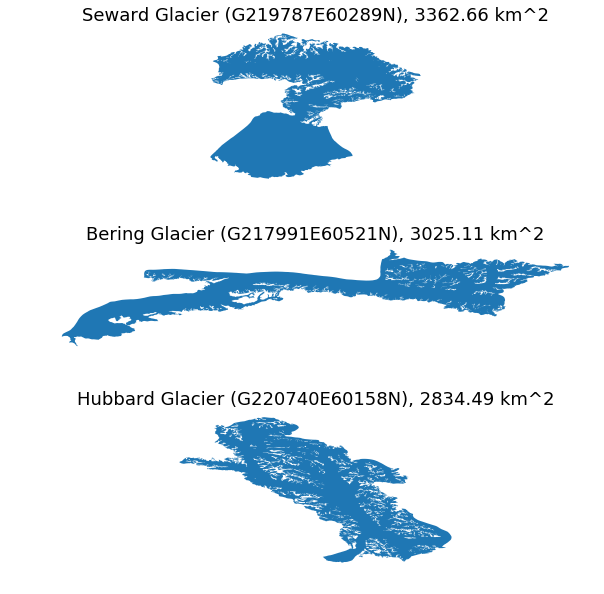

In [9]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r1_glims_largest_pd_1.plot(ax=ax1)
ax1.set_title(r1_glims_largest_name_1['glac_name'][0] + ' (' + r1_glims_largest_name_1['glac_id']
              [0] + '), ' + str(r1_glims_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r1_glims_largest_pd_2.plot(ax=ax2)
ax2.set_title(r1_glims_largest_name_2['glac_name'][1] + ' (' + r1_glims_largest_name_2['glac_id']
              [1] + '), ' + str(r1_glims_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot third largest glacier
r1_glims_largest_pd_3.plot(ax=ax3)
ax3.set_title(r1_glims_largest_name_3['glac_name'][2] + ' (' + r1_glims_largest_name_3['glac_id']
              [2] + '), ' + str(r1_glims_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

In [10]:
# Save 3 largest from GLIMS for Region 1 to shapefile
ws.save_3_largest(r1_glims_largest_pd_1, r1_glims_largest_pd_2, r1_glims_largest_pd_3, 1, 'GLIMS')

#### RGI Analysis

In [11]:
# Open RGI region 1 shapefile
rgi_polygons_r1 = ws.open_rgi_region(1)

In [12]:
# Open RGI Region 1 csv file with 10 largest glaciers
rgi_largest_r1 = ws.print_10_largest_rgi(1, do_print='false')

In [13]:
# Select 3 largest from RGI Region 1
r1_rgi_largest_name_1 = rgi_largest_r1.iloc[0:1]
r1_rgi_largest_pd_1 = rgi_polygons_r1[rgi_polygons_r1['GLIMSId']==r1_rgi_largest_name_1['GLIMSId'][0]]

r1_rgi_largest_name_2 = rgi_largest_r1.iloc[1:2]
r1_rgi_largest_pd_2 = rgi_polygons_r1[rgi_polygons_r1['GLIMSId']==r1_rgi_largest_name_2['GLIMSId'][1]]

r1_rgi_largest_name_3 = rgi_largest_r1.iloc[2:3]
r1_rgi_largest_pd_3 = rgi_polygons_r1[rgi_polygons_r1['GLIMSId']==r1_rgi_largest_name_3['GLIMSId'][2]]

In [14]:
# Plot the 3 largest RGI for Region 1
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r1_rgi_largest_pd_1.plot(ax=ax1)
ax1.set_title(str(r1_rgi_largest_name_1['Name'][0]) + ' (' + r1_rgi_largest_name_1['GLIMSId'][0]
              + '), ' + str(r1_rgi_largest_name_1['Area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r1_rgi_largest_pd_2.plot(ax=ax2)
ax2.set_title(str(r1_rgi_largest_name_2['Name'][1]) + ' (' + r1_rgi_largest_name_2['GLIMSId'][1]
              + '), ' + str(r1_rgi_largest_name_2['Area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot third largest glacier
r1_rgi_largest_pd_3.plot(ax=ax3)
ax3.set_title(str(r1_rgi_largest_name_3['Name'][2]) + ' (' + r1_rgi_largest_name_3['GLIMSId'][2]
              + '), ' + str(r1_rgi_largest_name_3['Area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

In [15]:
# Save 3 largest from RGI for Region 1 to shapefile
ws.save_3_largest(r1_rgi_largest_pd_1, r1_rgi_largest_pd_2, r1_rgi_largest_pd_3, 1, 'RGI')

#### Comparison Analysis

In [16]:
# Print GLIMS Region 1 csv file with 10 largest glaciers
ws.print_10_largest_glims(1)
print('')

GLIMS 10 Largest glaciers and their size for Region 1 - Alaska:

      Glacier ID               Area (km^2)      Glacier Name       Date of Measurement
      G219787E60289N             3362.660       Seward Glacier  2010-09-12T00:00:00
      G217991E60521N             3025.110       Bering Glacier  2010-09-10T00:00:00
      G220740E60158N             2834.490      Hubbard Glacier  2010-09-14T00:00:00
      G218695E60795N             1177.240        Logan Glacier  2005-08-12T00:00:00
      G220886E60666N             1053.720   Kaskawulsh Glacier  2010-08-04T00:00:00
      G216705E61883N             1028.800      Nabesna Glacier  2010-09-19T00:00:00
      G218130E60340N             1019.100       Yahtse Glacier  2010-09-19T00:00:00
      G218909E61392N              958.615      Klutlan Glacier  2005-08-12T00:00:00
      G213061E61274N              943.680     Columbia Glacier  2009-09-06T00:00:00
      G219155E61116N              925.340      Chitina Glacier  2005-08-12T00:00:00



In [17]:
# Print RGI Region 1 csv file with 10 largest glaciers
ws.print_10_largest_rgi(1)
print('')

RGI 10 Largest glaciers and their size for Region 1 - Alaska:

      Glacier ID               Area (km^2)      Glacier Name       Date of Measurement
      G219572E60177N             3362.656       Seward Glacier             20100912
      G217928E60461N             3025.115       Bering Glacier             20100910
      G220499E60427N             2834.493      Hubbard Glacier             20100914
      G219297E60730N             1177.246        Logan Glacier             20050812
      G220886E60666N             1053.721   Kaskawulsh Glacier             20100804
      G216705E61883N             1028.799      Nabesna Glacier             20100919
      G218284E60329N             1019.101       Yahtse Glacier             20100919
      G218909E61392N              958.616      Klutlan Glacier             20050812
      G219155E61116N              925.341      Chitina Glacier             20050812
      G219116E60102N              832.278      Agassiz Glacier             20100912



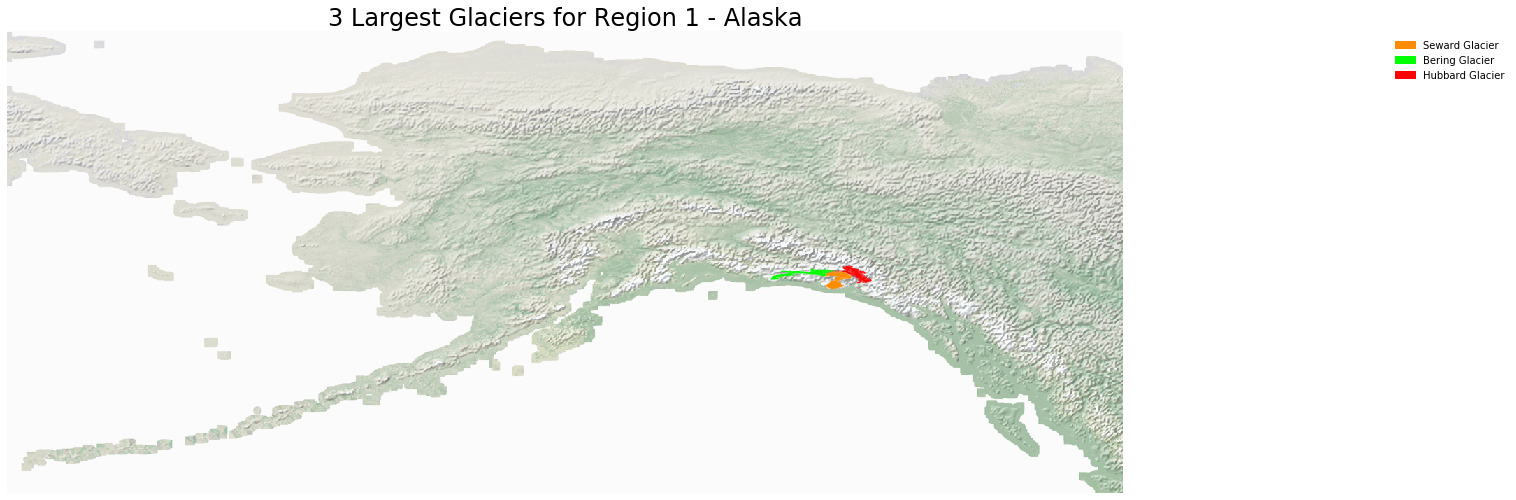

In [18]:
# Plot all 3 together on a natural earth basemap
# Set up legend
legend_colors = ['darkorange', 'lime', 'red']
legend_labels = [r1_glims_largest_name_1['glac_name'][0],
                 r1_glims_largest_name_2['glac_name'][1], r1_glims_largest_name_3['glac_name'][2]]
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = glacier_regions.loc[0:0].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 1
es.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest and the title and legend
r1_glims_largest_pd_1.plot(ax=ax, color="darkorange")
r1_glims_largest_pd_2.plot(ax=ax, color="lime")
r1_glims_largest_pd_3.plot(ax=ax, color="red")
ax.set_title('3 Largest Glaciers for Region 1 - Alaska', fontsize=24)
ax.legend(handles=legend_patches,
          facecolor="white",
          edgecolor="white",
          bbox_to_anchor=(1.35, 1))
ax.set_axis_off()

### Region 1 (Alaska) Results and Conclusions
#### Status - All Verified
The top 3 largest glaciers in Region 1 (Alaska) for both GLIMS and RGI match. No extra research needed to verify these.

Top 3 in order of largest to smallest (with area in km^2 rounded to the nearest square kilometer)
1. Seward Glacier - 3363 km^2
1. Bering Glacier - 3025 km^2
1. Hubbard Glacier - 2835 km^2

## -----------------------------------------------------------------------------------------------------
### Region 2 - Western Canada and USA

#### GLIMS Analysis

In [19]:
# Open GLIMS region 2 shapefile
glims_region_2_fp = "data/glims/processed/cleaned/glims_region_2_cleaned.shp"
glims_polygons_r2 = gpd.read_file(glims_region_2_fp)

In [20]:
# Open GLIMS Region 2 csv file with 10 largest glaciers
glims_largest_r2 = ws.print_10_largest_glims(2, do_print='false')

In [21]:
# Select 3 largest from GLIMS Region 2
r2_glims_largest_name_1 = glims_largest_r2.iloc[0:1]
r2_glims_largest_pd_1 = glims_polygons_r2[glims_polygons_r2['glac_id']==r2_glims_largest_name_1['glac_id'][0]]

r2_glims_largest_name_2 = glims_largest_r2.iloc[1:2]
r2_glims_largest_pd_2 = glims_polygons_r2[glims_polygons_r2['glac_id']==r2_glims_largest_name_2['glac_id'][1]]

r2_glims_largest_name_3 = glims_largest_r2.iloc[2:3]
r2_glims_largest_pd_3 = glims_polygons_r2[glims_polygons_r2['glac_id']==r2_glims_largest_name_3['glac_id'][2]]

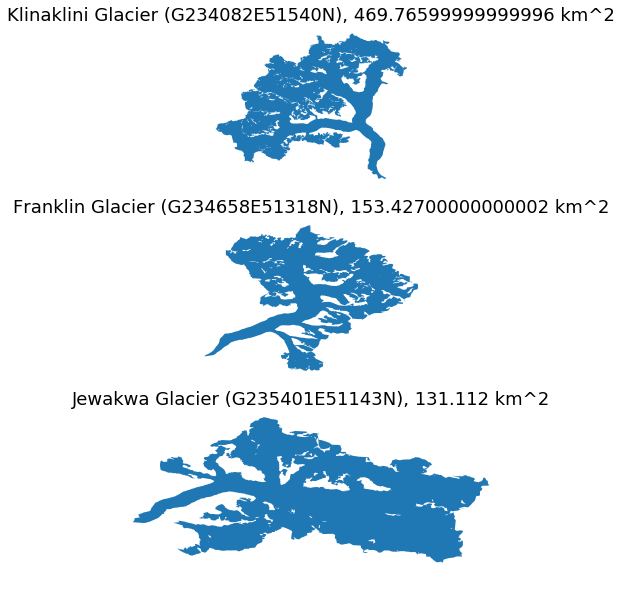

In [22]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r2_glims_largest_pd_1.plot(ax=ax1)
ax1.set_title(r2_glims_largest_name_1['glac_name'][0] + ' (' + r2_glims_largest_name_1['glac_id']
              [0] + '), ' + str(r2_glims_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r2_glims_largest_pd_2.plot(ax=ax2)
ax2.set_title(r2_glims_largest_name_2['glac_name'][1] + ' (' + r2_glims_largest_name_2['glac_id']
              [1] + '), ' + str(r2_glims_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot third largest glacier
r2_glims_largest_pd_3.plot(ax=ax3)
ax3.set_title(r2_glims_largest_name_3['glac_name'][2] + ' (' + r2_glims_largest_name_3['glac_id']
              [2] + '), ' + str(r2_glims_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

In [23]:
# Save 3 largest from GLIMS for Region 2 to shapefile
ws.save_3_largest(r2_glims_largest_pd_1, r2_glims_largest_pd_2, r2_glims_largest_pd_3, 2, 'GLIMS')

#### RGI Analysis

In [24]:
# Open RGI region 2 shapefile
rgi_polygons_r2 = ws.open_rgi_region(2)

In [25]:
# Open RGI Region 2 csv file with 10 largest glaciers
rgi_largest_r2 = ws.print_10_largest_rgi(2, do_print='false')

In [26]:
# Select 3 largest from RGI Region 2
r2_rgi_largest_name_1 = rgi_largest_r2.iloc[0:1]
r2_rgi_largest_pd_1 = rgi_polygons_r2[rgi_polygons_r2['GLIMSId']==r2_rgi_largest_name_1['GLIMSId'][0]]

r2_rgi_largest_name_2 = rgi_largest_r2.iloc[1:2]
r2_rgi_largest_pd_2 = rgi_polygons_r2[rgi_polygons_r2['GLIMSId']==r2_rgi_largest_name_2['GLIMSId'][1]]

r2_rgi_largest_name_3 = rgi_largest_r2.iloc[2:3]
r2_rgi_largest_pd_3 = rgi_polygons_r2[rgi_polygons_r2['GLIMSId']==r2_rgi_largest_name_3['GLIMSId'][2]]

In [27]:
# Check the 4th largest for RGI as well
r2_rgi_largest_name_4 = rgi_largest_r2.iloc[3:4]
r2_rgi_largest_pd_4 = rgi_polygons_r2[rgi_polygons_r2['GLIMSId']==r2_rgi_largest_name_4['GLIMSId'][3]]

In [28]:
r2_rgi_largest_pd_4

RGIId         GLIMSId   BgnDate   EndDate   CenLon   CenLat  \
3585  RGI60-02.03586  G235376E51153N  20049999  20069999 -124.624  51.1525   

     O1Region O2Region     Area  Zmin  ...  Aspect   Lmax  Status  Connect  \
3585        2        2  131.112   697  ...     276  23254       0        0   

      Form  TermType  Surging  Linkages  Name  \
3585     0         0        0         9  None   

                                               geometry  
3585  POLYGON ((-124.6618999999999 51.21381400000007...  

[1 rows x 23 columns]

In [29]:
# Plot the 3 largest RGI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r2_rgi_largest_pd_1.plot(ax=ax1)
ax1.set_title(str(r2_rgi_largest_name_1['Name'][0]) + ' (' + r2_rgi_largest_name_1['GLIMSId'][0]
              + '), ' + str(r2_rgi_largest_name_1['Area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r2_rgi_largest_pd_2.plot(ax=ax2)
ax2.set_title(str(r2_rgi_largest_name_2['Name'][1]) + ' (' + r2_rgi_largest_name_2['GLIMSId'][1]
              + '), ' + str(r2_rgi_largest_name_2['Area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot third largest glacier
r2_rgi_largest_pd_3.plot(ax=ax3)
ax3.set_title(str(r2_rgi_largest_name_3['Name'][2]) + ' (' + r2_rgi_largest_name_3['GLIMSId'][2]
              + '), ' + str(r2_rgi_largest_name_3['Area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

In [30]:
# Save 3 largest from RGI for Region 2 to shapefile
ws.save_3_largest(r2_rgi_largest_pd_1, r2_rgi_largest_pd_2, r2_rgi_largest_pd_3, 2, 'RGI')

#### Comparison Analysis

In [31]:
# Print GLIMS Region 2 csv file with 10 largest glaciers
ws.print_10_largest_glims(2)
print('')

GLIMS 10 Largest glaciers and their size for Region 2 - Western Canada and USA:

      Glacier ID               Area (km^2)      Glacier Name       Date of Measurement
      G234082E51540N             469.7660     Klinaklini Glacier  2004-07-22T00:00:00
      G234658E51318N             153.4270       Franklin Glacier  2004-07-22T00:00:00
      G235401E51143N             131.1120        Jewakwa Glacier  2004-08-09T00:00:00
      G236376E50799N              81.9767         Bridge Glacier  2004-08-09T00:00:00
      G233819E52013N              73.2519       Jacobsen Glacier  2004-07-22T00:00:00
      G236186E50856N              71.6418  Stanley Smith Glacier  2004-08-09T00:00:00
      G234015E51942N              66.3389       Talchako Glacier  2004-07-22T00:00:00
      G234818E51352N              58.9104      Tiedemann Glacier  2004-07-22T00:00:00
      G234015E51359N              57.6494                   None  2004-07-22T00:00:00
      G233836E51464N              56.8717       Pashleth G

In [32]:
# Print RGI Region 2 csv file with 10 largest glaciers
ws.print_10_largest_rgi(2)
print('')

RGI 10 Largest glaciers and their size for Region 2 - Western Canada and USA:

      Glacier ID               Area (km^2)      Glacier Name       Date of Measurement
      G234050E51502N              469.766                  NaN             20049999
      G234663E51321N              153.427                  NaN             20049999
      G235390E51067N              136.850                  NaN             20049999
      G235376E51153N              131.112                  NaN             20049999
      G236361E50822N               81.977                  NaN             20049999
      G233852E52014N               73.252                  NaN             20049999
      G236187E50855N               71.642                  NaN             20049999
      G234038E51945N               66.339                  NaN             20049999
      G234864E51343N               58.910                  NaN             20049999
      G234034E51356N               57.649                  NaN             200

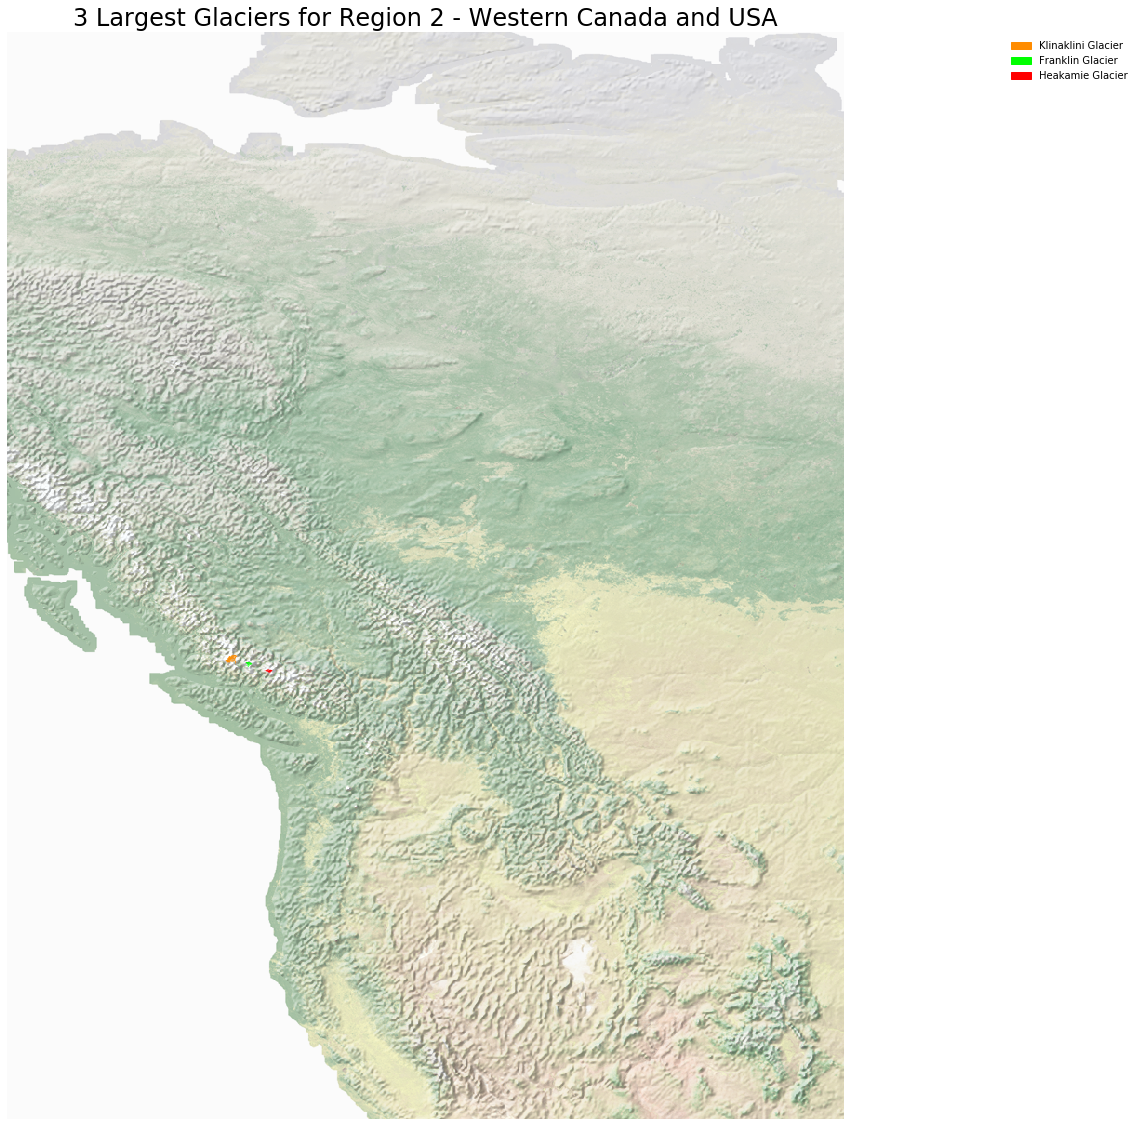

In [33]:
# Plot all 3 together on a natural earth basemap
# Set up legend
legend_colors = ['darkorange', 'lime', 'red']
legend_labels = [r2_glims_largest_name_1['glac_name'][0], r2_glims_largest_name_2['glac_name'][1], 'Heakamie Glacier']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = glacier_regions.loc[1:1].total_bounds
ax.set_xlim(minx, maxx) 
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 2
es.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent = ne_src_extent,
            ax=ax)

# Plot 3 largest plus the title and legend
r2_glims_largest_pd_1.plot(ax=ax, color="darkorange")
r2_glims_largest_pd_2.plot(ax=ax, color="lime")
r2_rgi_largest_pd_3.plot(ax=ax, color="red")
ax.set_title('3 Largest Glaciers for Region 2 - Western Canada and USA', fontsize=24)
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         bbox_to_anchor = (1.35,1))
ax.set_axis_off()

### Region 2 (Western Canada and USA) Results and Conclusions
#### Status - All Verified
Although, RGI doesn't have the names of the glaciers, by plotting them and doing a manual inspection, it's clear that the top 2 largest glaciers in Region 2, Klinaklini Glacier and Franklin Glacier, match for both GLIMS and RGI. 

The third largest between the two databases does not match. The 3rd largest for GLIMS, Jewakwa Glaicer, is the 4th largest for RGI. I investigated why GLIMS doesn't seem to have 3rd largest shown for RGI in its database. First, I found that the name of RGI's 3rd largest Region 2 glacier is called Heakamie Glacier using a web site called mapcarta.com. Second, I inspected the dates of the measurements for all the glaciers; they are all for 2004, so it's not a matter of GLIMS having a newer measurement of Heakamie Glacier, which could be a smaller outline. Then, I used the GLIMS Glacier Viewer (http://www.glims.org/maps/glims) to look at both GLIMS and RGI outlines on an interactive map. The GLIMS Glacier Viewer is an interactive map which gives a view of data in the GLIMS Glacier Database along with other layers one of which is the RGI data. Using that tool, I found that GLIMS is missing the Heakamie Glacier outline from it's database, so the 3rd largest glacier for Region 2 is Heakamie Glacier as shown in the RGI database.

Top 3 in order of largest to smallest (with area in km^2 rounded to the nearest square kilometer)

1. Klinaklini Glacier - 470 km^2
1. Franklin Glacier - 153 km^2
1. Heakamie Glacier - 137 km^2

## --------------------------------------------------------------------------------------------------------------
### Region 3 - Arctic Canada, North

#### GLIMS Analysis

In [34]:
# Open GLIMS region 3 shapefile
glims_region_3_fp = "data/glims/processed/cleaned/glims_region_3_cleaned.shp"
glims_polygons_r3 = gpd.read_file(glims_region_3_fp)

In [35]:
# Open GLIMS Region 3 csv file with 10 largest glaciers
glims_largest_r3 = ws.print_10_largest_glims(3, do_print='false')

In [36]:
# Select 3 largest from GLIMS Region 3
r3_glims_largest_name_1 = glims_largest_r3.iloc[0:1]
r3_glims_largest_pd_1 = glims_polygons_r3[glims_polygons_r3['glac_id']==r3_glims_largest_name_1['glac_id'][0]]

r3_glims_largest_name_2 = glims_largest_r3.iloc[1:2]
r3_glims_largest_pd_2 = glims_polygons_r3[glims_polygons_r3['glac_id']==r3_glims_largest_name_2['glac_id'][1]]

r3_glims_largest_name_3 = glims_largest_r3.iloc[2:3]
r3_glims_largest_pd_3 = glims_polygons_r3[glims_polygons_r3['glac_id']==r3_glims_largest_name_3['glac_id'][2]]

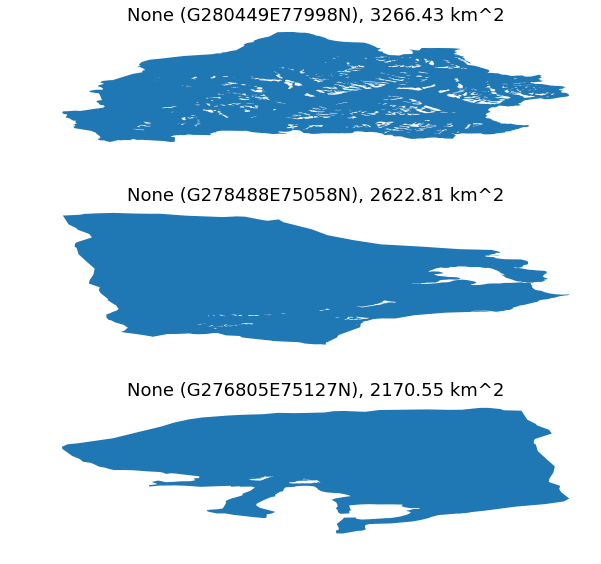

In [37]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r3_glims_largest_pd_1.plot(ax=ax1)
ax1.set_title(r3_glims_largest_name_1['glac_name'][0] + ' (' + r3_glims_largest_name_1['glac_id']
              [0] + '), ' + str(r3_glims_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r3_glims_largest_pd_2.plot(ax=ax2)
ax2.set_title(r3_glims_largest_name_2['glac_name'][1] + ' (' + r3_glims_largest_name_2['glac_id']
              [1] + '), ' + str(r3_glims_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot third largest glacier
r3_glims_largest_pd_3.plot(ax=ax3)
ax3.set_title(r3_glims_largest_name_3['glac_name'][2] + ' (' + r3_glims_largest_name_3['glac_id']
              [2] + '), ' + str(r3_glims_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

In [38]:
# Save 3 largest from GLIMS for Region 3 to shapefile
ws.save_3_largest(r3_glims_largest_pd_1, r3_glims_largest_pd_2, r3_glims_largest_pd_3, 3, 'GLIMS')

#### RGI Analysis

In [39]:
# Open RGI region 3 shapefile
rgi_polygons_r3 = ws.open_rgi_region(3)

In [40]:
# Open RGI Region 3 csv file with 10 largest glaciers
rgi_largest_r3 = ws.print_10_largest_rgi(3, do_print='false')

In [41]:
# Select 3 largest from RGI Region 3
r3_rgi_largest_name_1 = rgi_largest_r3.iloc[0:1]
r3_rgi_largest_pd_1 = rgi_polygons_r3[rgi_polygons_r3['GLIMSId']==r3_rgi_largest_name_1['GLIMSId'][0]]

r3_rgi_largest_name_2 = rgi_largest_r3.iloc[1:2]
r3_rgi_largest_pd_2 = rgi_polygons_r3[rgi_polygons_r3['GLIMSId']==r3_rgi_largest_name_2['GLIMSId'][1]]

r3_rgi_largest_name_3 = rgi_largest_r3.iloc[2:3]
r3_rgi_largest_pd_3 = rgi_polygons_r3[rgi_polygons_r3['GLIMSId']==r3_rgi_largest_name_3['GLIMSId'][2]]

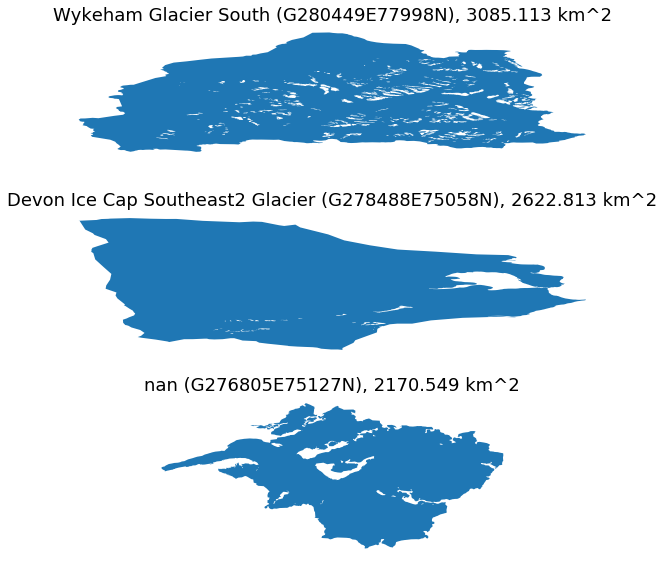

In [42]:
# Plot the 3 largest RGI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r3_rgi_largest_pd_1.plot(ax=ax1)
ax1.set_title(str(r3_rgi_largest_name_1['Name'][0]) + ' (' + r3_rgi_largest_name_1['GLIMSId'][0]
              + '), ' + str(r3_rgi_largest_name_1['Area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r3_rgi_largest_pd_2.plot(ax=ax2)
ax2.set_title(str(r3_rgi_largest_name_2['Name'][1]) + ' (' + r3_rgi_largest_name_2['GLIMSId'][1]
              + '), ' + str(r3_rgi_largest_name_2['Area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot third largest glacier
r2_rgi_largest_pd_3.plot(ax=ax3)
ax3.set_title(str(r3_rgi_largest_name_3['Name'][2]) + ' (' + r3_rgi_largest_name_3['GLIMSId'][2]
              + '), ' + str(r3_rgi_largest_name_3['Area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

In [43]:
# Save 3 largest from RGI for Region 3 to shapefile
ws.save_3_largest(r3_rgi_largest_pd_1, r3_rgi_largest_pd_2, r3_rgi_largest_pd_3, 3, 'RGI')

#### Comparison Analysis

In [44]:
# Print GLIMS Region 3 csv file with 10 largest glaciers
ws.print_10_largest_glims(3)
print('')

GLIMS 10 Largest glaciers and their size for Region 3 - Arctic Canada, North:

      Glacier ID               Area (km^2)      Glacier Name       Date of Measurement
      G280449E77998N              3266.43                 None  1999-07-09T00:00:00
      G278488E75058N              2622.81                 None  1999-06-15T00:00:00
      G276805E75127N              2170.55                 None  1999-06-15T00:00:00
      G280783E77677N              1891.12                 None  1999-07-09T00:00:00
      G274800E74935N              1780.65                 None  1999-06-15T00:00:00
      G279922E76831N              1746.58                 None  2002-07-19T17:58:00
      G284432E82157N              1734.50          M'Clintock,  1999-06-15T00:00:00
      G283470E80355N              1594.48                 None  1999-06-15T00:00:00
      G281841E78455N              1530.28                 None  1999-07-09T00:00:00
      G279351E78361N              1436.01                 None  1999-07-09T00:

In [45]:
# Print RGI Region 3 csv file with 10 largest glaciers
ws.print_10_largest_rgi(3)
print('')

RGI 10 Largest glaciers and their size for Region 3 - Arctic Canada, North:

      Glacier ID               Area (km^2)      Glacier Name       Date of Measurement
      G280449E77998N             3085.113             Wykeham Glacier South             19999999
      G278488E75058N             2622.813  Devon Ice Cap Southeast2 Glacier             19999999
      G276805E75127N             2170.549                               NaN             19999999
      G280783E77677N             1892.023               Easter Island South             19999999
      G274800E74935N             1780.453                               NaN             19999999
      G279922E76831N             1741.310                            Mittie             19999999
      G284432E82157N             1734.500                         MClintock             19999999
      G283470E80355N             1594.482                        DIberville             19999999
      G281841E78455N             1530.284                   

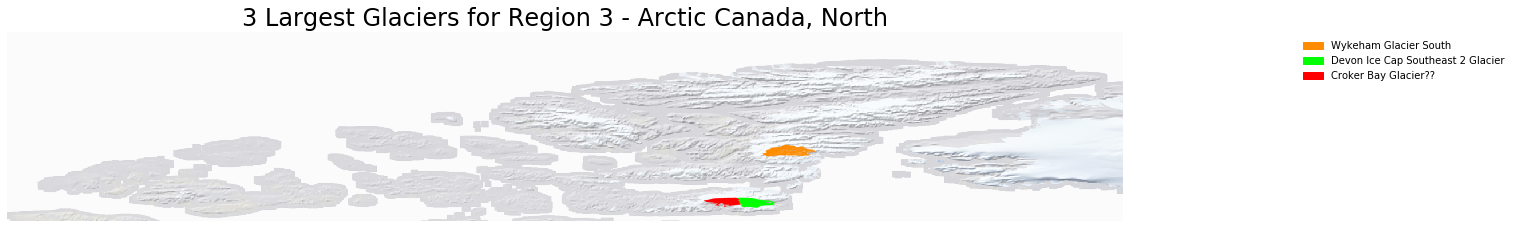

In [46]:
# Plot all 3 together on a natural earth basemap
# Set up legend
legend_colors = ['darkorange', 'lime', 'red']
legend_labels = ['Wykeham Glacier South',
                 'Devon Ice Cap Southeast 2 Glacier', 'Croker Bay Glacier??']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = glacier_regions.loc[2:2].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 3
es.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest plus the title and legend
r3_glims_largest_pd_1.plot(ax=ax, color="darkorange")
r3_glims_largest_pd_2.plot(ax=ax, color="lime")
r3_glims_largest_pd_3.plot(ax=ax, color="red")
#r3_rgi_largest_pd_1.plot(ax=ax, color="blue")
ax.set_title('3 Largest Glaciers for Region 3 - Arctic Canada, North', fontsize=24)
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         bbox_to_anchor = (1.35,1))
ax.set_axis_off()

##### Ice Cap Analysis

In [79]:
# Open and print the GLIMS and RGI sizes of the ice caps for Region 3
print('Largest 4 Ice Caps in Region 3')
region_3_ice_caps_fp = 'data/comparison/region-3-ice-cap-sizes.csv'
region_3_ice_caps = pd.read_csv(region_3_ice_caps_fp)
region_3_ice_caps

Largest 4 Ice Caps in Region 3


Ice Cap Name  GLIMS Area km^2  RGI Area km^2  Average Area km^2
0             Devon Ice Cap     14856.257376   14855.857053       14856.057215
1  Prince of Wales Icefield     19142.271791   19141.936237       19142.104014
2           Agassiz Ice Cap     21120.310421   21127.447999       21123.879210
3      N Ellesmere Icefield     27220.645285   27203.053196       27211.849240

In [48]:
# Open the GLIMS devon ice cap with the glacier outlines
devon_glims_fp = 'data/glims/processed/ice-caps/not-dissolved/devon-outline_r3.shp'
devon_glims = gpd.read_file(devon_glims_fp)

# Get 3 largest
print('Largest 3 Glaciers on Devon Ice Cap (Region 3)')
devon_glims_top_3 = devon_glims[['glac_id', 'db_area', 'glac_name', 'src_date']].nlargest(3, 'db_area')
devon_glims_top_3

glac_id  db_area glac_name             src_date
56   G278488E75058N  2622.81      None  1999-06-15T00:00:00
169  G276805E75127N  2170.55      None  1999-06-15T00:00:00
40   G274800E74935N  1780.65      None  1999-06-15T00:00:00

In [49]:
# Open the GLIMS Prince of Wales icefield with the glacier outlines
pow_glims_fp = 'data/glims/processed/ice-caps/not-dissolved/prince-wales-outline_r3.shp'
pow_glims = gpd.read_file(pow_glims_fp)

# Get 3 largest
print('Largest 3 Glaciers on Prince of Wales Icefield (Region 3)')
pow_glims_top_3 = pow_glims[['glac_id', 'db_area', 'glac_name', 'src_date']].nlargest(3, 'db_area')
pow_glims_top_3

glac_id  db_area glac_name             src_date
122  G280449E77998N  3266.43      None  1999-07-09T00:00:00
78   G280783E77677N  1891.12      None  1999-07-09T00:00:00
0    G281841E78455N  1530.28      None  1999-07-09T00:00:00

In [50]:
# Open the GLIMS Agassiz ice cap with the glacier outlines
agassiz_glims_fp = 'data/glims/processed/ice-caps/not-dissolved/agassiz-outline_r3.shp'
agassiz_glims = gpd.read_file(agassiz_glims_fp)

# Get 3 largest
print('Largest 3 Glaciers on Agassiz Ice Cap (Region 3)')
agassiz_glims_top_3 = agassiz_glims[['glac_id', 'db_area', 'glac_name', 'src_date']].nlargest(3, 'db_area')
agassiz_glims_top_3

glac_id  db_area glac_name             src_date
344  G283470E80355N  1594.48      None  1999-06-15T00:00:00
203  G286421E80454N  1092.60      None  1999-06-15T00:00:00
638  G284116E79986N  1087.47      None  1999-06-15T00:00:00

In [51]:
# Open the GLIMS N Ellesmere icefield with the glacier outlines
ellesmere_glims_fp = 'data/glims/processed/ice-caps/not-dissolved/ellesmere-outline_r3.shp'
ellesmere_glims = gpd.read_file(ellesmere_glims_fp)

# Get 3 largest
print('Largest 3 Glaciers on North Ellesmere Icefield (Region 3)')
ellesmere_glims_top_3 = ellesmere_glims[['glac_id', 'db_area', 'glac_name', 'src_date']].nlargest(3, 'db_area')
ellesmere_glims_top_3

glac_id  db_area    glac_name             src_date
1722  G284432E82157N  1734.50  M'Clintock,  1999-06-15T00:00:00
21    G287533E82397N  1384.54    Disraeli,  1999-06-15T00:00:00
582   G277056E81417N  1214.84        Otto,  1999-06-15T00:00:00

### Region 3 Arctic Canada, North Results and Conclusions
#### Status - All Verified

Region 3 contains ice caps and some of the largest glaciers as listed by GLIMS and RGI are actually ice caps. Therefore, I needed to explore the sizes of the ice caps and then the sizes of the individual outlet glaciers on the ice caps as noted in the Methods section at the top of this notebook.

Top 3 ice caps in Region 3 are the following (with average area in km^2 rounded to the nearest square kilometer) and the largest 3 glaciers on those ice caps are listed underneath each. However, since two of the largest glaciers in Region 3 are on Devon Ice Cap which is the 4th largest ice cap, so this is listed as well.
1. Northern Ellesmere Icefiled - 27,212 km^2
  * M'Clintock Glacier - 1735 km^2
  * Disraeli Glacier - 1385 km^2
  * Otto Glacier - 1215 km^2
1. Agassiz Ice Cap - 21,124 km^2
  * D'Iberville - 1594 km^2
  * John Richardson Bay Glacier - 1093 km^2
  * Unnamed Glacier - 1087 km^2
1. Prince of Wales Icefield - 19,142 km^2
  * Wykeham Glacier - 3266 km^2
  * Island Easter South (South Margin) Glacier - 1891 km^2
  * Ekblaw Glacier - 1530 km^2
1. Devon Ice Cap - 14,856 km^2
  * Devon Ice Cap Southeast 2 Glacier - 2623 km^2
  * Croker Bay Glacier - 2171 km^2
  * Unnamed Glacier - 1781 km^2

By inspecting the outlines on a map, it appears that the top 3 for GLIMS and RGI are the same glaciers, however, the RGI area listed for the largest glacier is smaller than for GLIMS with a similar date probably because two different institutions supplied the outlines to each of the databases and they used different methods for calculating the outline.

Top 3 in order of largest to smallest (with area in km^2 rounded to the nearest square kilometer)

1. Wykeham Glacier - 3266 km^2
1. Devon Ice Cap Southeast 2 Glacier - 2623 km^2
1. Croker Bay Glacier - 2171 km^2

# -----------------------------------------------------------------------------------------------------------
### Region 4 - Arctic Canada, South

#### GLIMS Analysis

In [52]:
# Open GLIMS region 4 shapefile
glims_region_4_fp = "data/glims/processed/cleaned/glims_region_4_cleaned.shp"
glims_polygons_r4 = gpd.read_file(glims_region_4_fp)

In [53]:
# Open GLIMS Region 4 csv file with 10 largest glaciers
glims_largest_r4 = ws.print_10_largest_glims(4, do_print='false')

In [65]:
# Select 3 largest from GLIMS Region 4
r4_glims_largest_name_1 = glims_largest_r4.iloc[0:1]
r4_glims_largest_pd_1 = glims_polygons_r4[glims_polygons_r4['glac_id']==r4_largest_name_1['glac_id'][0]]

r4_glims_largest_name_2 = glims_largest_r4.iloc[1:2]
r4_glims_largest_pd_2 = glims_polygons_r4[glims_polygons_r4['glac_id']==r4_largest_name_2['glac_id'][1]]

r4_glims_largest_name_3 = glims_largest_r4.iloc[2:3]
r4_glims_largest_pd_3 = glims_polygons_r4[glims_polygons_r4['glac_id']==r4_largest_name_3['glac_id'][2]]

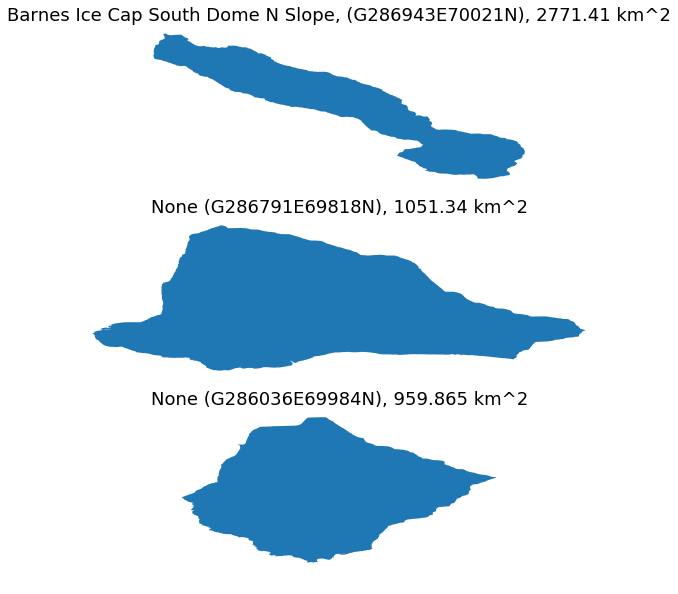

In [55]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r4_largest_pd_1.plot(ax=ax1)
ax1.set_title(r4_largest_name_1['glac_name'][0] + ' (' + r4_largest_name_1['glac_id']
              [0] + '), ' + str(r4_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r4_largest_pd_2.plot(ax=ax2)
ax2.set_title(r4_largest_name_2['glac_name'][1] + ' (' + r4_largest_name_2['glac_id']
              [1] + '), ' + str(r4_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r4_largest_pd_3.plot(ax=ax3)
ax3.set_title(r4_largest_name_3['glac_name'][2] + ' (' + r4_largest_name_3['glac_id']
              [2] + '), ' + str(r4_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

In [56]:
# Save 3 largest from GLIMS for Region 1 to shapefile
ws.save_3_largest(r4_largest_pd_1, r4_largest_pd_2, r4_largest_pd_3, 1, 'GLIMS')

#### RGI Analysis

In [57]:
# Open RGI region 1 shapefile
rgi_polygons_r4 = ws.open_rgi_region(4)

In [58]:
# Open and print RGI Region 4 csv file with 10 largest glaciers
rgi_largest_r4 = ws.print_10_largest_rgi(4, do_print='false')

In [59]:
# Select 3 largest from RGI Region 4
r4_rgi_largest_name_1 = rgi_largest_r4.iloc[0:1]
r4_rgi_largest_pd_1 = rgi_polygons_r4[rgi_polygons_r4['GLIMSId']==r4_rgi_largest_name_1['GLIMSId'][0]]

r4_rgi_largest_name_2 = rgi_largest_r4.iloc[1:2]
r4_rgi_largest_pd_2 = rgi_polygons_r4[rgi_polygons_r4['GLIMSId']==r4_rgi_largest_name_2['GLIMSId'][1]]

r4_rgi_largest_name_3 = rgi_largest_r4.iloc[2:3]
r4_rgi_largest_pd_3 = rgi_polygons_r4[rgi_polygons_r4['GLIMSId']==r4_rgi_largest_name_3['GLIMSId'][2]]

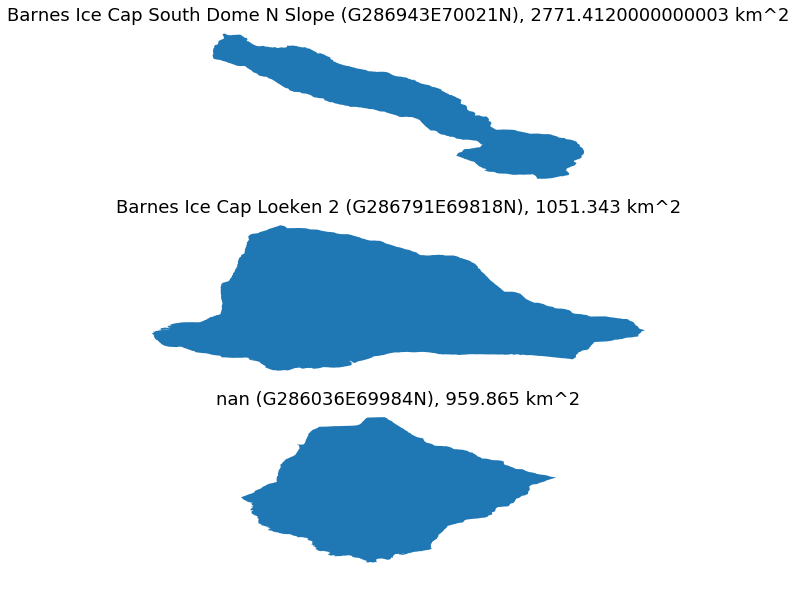

In [60]:
# Plot the 3 largest RGI for Region 4
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r4_rgi_largest_pd_1.plot(ax=ax1)
ax1.set_title(str(r4_rgi_largest_name_1['Name'][0]) + ' (' + r4_rgi_largest_name_1['GLIMSId'][0]
              + '), ' + str(r4_rgi_largest_name_1['Area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r4_rgi_largest_pd_2.plot(ax=ax2)
ax2.set_title(str(r4_rgi_largest_name_2['Name'][1]) + ' (' + r4_rgi_largest_name_2['GLIMSId'][1]
              + '), ' + str(r4_rgi_largest_name_2['Area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot third largest glacier
r4_rgi_largest_pd_3.plot(ax=ax3)
ax3.set_title(str(r4_rgi_largest_name_3['Name'][2]) + ' (' + r4_rgi_largest_name_3['GLIMSId'][2]
              + '), ' + str(r4_rgi_largest_name_3['Area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

In [61]:
# Save 3 largest from RGI for Region 4 to shapefile
ws.save_3_largest(r4_rgi_largest_pd_1, r4_rgi_largest_pd_2, r4_rgi_largest_pd_3, 1, 'RGI')

#### Comparison Analysis

In [62]:
# Print GLIMS Region 4 csv file with 10 largest glaciers
ws.print_10_largest_glims(4)
print('')

GLIMS 10 Largest glaciers and their size for Region 4 - Arctic Canada, South:

      Glacier ID               Area (km^2)      Glacier Name       Date of Measurement
      G286943E70021N             2771.410  Barnes Ice Cap South Dome N Slope,  2002-08-02T00:00:00
      G286791E69818N             1051.340                                None  2000-07-27T00:00:00
      G286036E69984N              959.865                                None  2000-07-27T00:00:00
      G293919E67124N              811.875                                None  2000-08-15T00:00:00
      G294647E67092N              661.739                                None  2000-08-13T00:00:00
      G285584E70223N              585.292                                None  2002-08-02T00:00:00
      G281633E73315N              576.155                                None  2001-08-09T00:00:00
      G294456E67304N              468.392                                None  2000-08-13T00:00:00
      G284216E72339N              420.095 

In [63]:
# Print RGI Region 4 csv file with 10 largest glaciers
ws.print_10_largest_rgi(4)
print('')

RGI 10 Largest glaciers and their size for Region 4 - Arctic Canada, South:

      Glacier ID               Area (km^2)      Glacier Name       Date of Measurement
      G286943E70021N             2771.412  Barnes Ice Cap South Dome N Slope             20020802
      G286791E69818N             1051.343            Barnes Ice Cap Loeken 2             20000727
      G286036E69984N              959.865                                NaN             20000727
      G293919E67124N              811.874                                NaN             20000899
      G294647E67092N              661.740                                NaN             20000813
      G285584E70223N              585.292                                NaN             20020802
      G281633E73315N              576.156                                NaN             20010809
      G294456E67304N              468.392                                NaN             20000813
      G284216E72339N              420.095           

In [80]:
# Plot all 3 together on a natural earth basemap
# Set up legend
legend_colors = ['darkorange', 'lime', 'red']
legend_labels = [r4_glims_largest_name_1['glac_name'][0],
                 r4_rgi_largest_name_2['Name'][1], r4_glims_largest_name_3['glac_name'][2]]
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = glacier_regions.loc[3:3].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 1
es.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest and the title and legend
r4_glims_largest_pd_1.plot(ax=ax, color="darkorange")
r4_glims_largest_pd_2.plot(ax=ax, color="lime")
r4_glims_largest_pd_3.plot(ax=ax, color="red")
ax.set_title(
    '3 Largest Glaciers for Region 4 - Arctic Canda, North', fontsize=24)
ax.legend(handles=legend_patches,
          facecolor="white",
          edgecolor="white",
          bbox_to_anchor=(1.35, 1))
ax.set_axis_off()

##### Ice Cap Analysis

In [77]:
# Open and print the GLIMS and RGI sizes of the ice caps for Region 4
print('Largest 3 Ice Caps for Region 4')
region_4_ice_caps_fp = 'data/comparison/region-4-ice-cap-sizes.csv'
region_4_ice_caps = pd.read_csv(region_4_ice_caps_fp)
region_4_ice_caps

Largest 3 Ice Caps for Region 4


Ice Cap Name  GLIMS Area km^2  RGI Area km^2  Average Area km^2
0  Barnes Ice Cap      5862.719932    5862.719941        5862.719936
1   Penny Ice Cap      7109.437845    7109.438193        7109.438019
2    Bylot Island      4875.241609    4875.242384        4875.241997

In [74]:
# Open the GLIMS barnes ice cap with the glacier outlines
barnes_glims_fp = 'data/glims/processed/ice-caps/not-dissolved/barnes-outline_r4.shp'
barnes_glims = gpd.read_file(barnes_glims_fp)

# Get 3 largest
print('Largest 3 Glaciers on Barnes Ice Cap (Region 4)')
barnes_glims_top_3 = barnes_glims[['glac_id', 'db_area', 'glac_name', 'src_date']].nlargest(3, 'db_area')
barnes_glims_top_3

Largest 3 Glaciers on Barnes Ice Cap (Region 4)


glac_id   db_area                           glac_name  \
3  G286943E70021N  2771.410  Barnes Ice Cap South Dome N Slope,   
0  G286791E69818N  1051.340                                None   
1  G286036E69984N   959.865                                None   

              src_date  
3  2002-08-02T00:00:00  
0  2000-07-27T00:00:00  
1  2000-07-27T00:00:00

In [75]:
# Open the GLIMS penny ice cap with the glacier outlines
penny_glims_fp = 'data/glims/processed/ice-caps/not-dissolved/penny-outline_r4.shp'
penny_glims = gpd.read_file(penny_glims_fp)

# Get 3 largest
print('Largest 3 Glaciers on Penny Ice Cap (Region 4)')
penny_glims_top_3 = penny_glims[['glac_id', 'db_area', 'glac_name', 'src_date']].nlargest(3, 'db_area')
penny_glims_top_3

Largest 3 Glaciers on Penny Ice Cap (Region 4)


glac_id  db_area glac_name             src_date
428  G293919E67124N  811.875      None  2000-08-15T00:00:00
463  G294647E67092N  661.739      None  2000-08-13T00:00:00
577  G294456E67304N  468.392      None  2000-08-13T00:00:00

In [76]:
# Open the GLIMS bylot island with the glacier outlines
bylot_glims_fp = 'data/glims/processed/ice-caps/not-dissolved/bylot-outline_r4.shp'
bylot_glims = gpd.read_file(bylot_glims_fp)

# Get 3 largest
print('Largest 3 Glaciers on Bylot Island (Region 4)')
bylot_glims_top_3 = bylot_glims[['glac_id', 'db_area', 'glac_name', 'src_date']].nlargest(3, 'db_area')
bylot_glims_top_3

Largest 3 Glaciers on Bylot Island (Region 4)


glac_id  db_area glac_name             src_date
427  G281633E73315N  576.155      None  2001-08-09T00:00:00
256  G281104E73387N  350.530      None  2001-08-09T00:00:00
315  G282595E73104N  345.869      None  2000-08-10T00:00:00

### Region 4 Arctic Canada, South Results and Conclusions
#### Status - All Verified

Region 4 contains ice caps and some of the largest glaciers as listed by GLIMS and RGI are on the ice caps. Therefore, I needed to explore the sizes of the ice caps and then the sizes of the individual outlet glaciers on the ice caps as noted in the Methods section at the top of this notebook.

There are only 3 ice caps in Region 4; they are the following (with average area in km^2 rounded to the nearest square kilometer) and the largest 3 glaciers on those ice caps are listed underneath each. 
1. Barnes Ice Cap - 5,863 km^2
  * Barnes Ice Cap South Dome N Slope Glacier - 2,771 km^2
  * Barnes Ice Cap Loeken 2 - 1,051 km^2
  * Unnamed Glacier - 960 km^2
1. Penny Ice Cap - 7,109 km^2
  * Unnamed Glacier - 812 km^2
  * Unnamed Glacier - 662 km^2
  * Unnamed Glacier - 468 km^2
1. Bylot Island - 4,875 km^2
  * Unnamed Glacier - 576 km^2
  * Unnamed Glacier - 351 km^2
  * Unnamed Glacier - 346 km^2

By inspecting the outlines on a map, it appears that the top 3 for GLIMS and RGI are the same glaciers. They also all occurr on Barnes Ice Cap.

Top 3 in order of largest to smallest (with area in km^2 rounded to the nearest square kilometer)

1. Barnes Ice Cap South Dome N Slope - 2,771 km^2
1. Barnes Ice Cap Loeken 2 - 1,051 km^2
1. Unnamed Glacier - 960 km^2

# -----------------------------------------------------------------------------------------------
### Region 5 - Greenland Periphery

##### GLIMS Analysis

In [81]:
# Open GLIMS region 5 shapefile
glims_region_5_fp = "data/glims/processed/cleaned/glims_region_5_cleaned.shp"
glims_polygons_r5 = gpd.read_file(glims_region_5_fp)

In [82]:
# Open GLIMS Region 5 csv file with 10 largest glaciers
glims_largest_r5 = ws.print_10_largest_glims(5, do_print="false")

In [83]:
# Select 3 largest from GLIMS Region 5
r5_glims_largest_name_1 = glims_largest_r5.iloc[0:1]
r5_glims_largest_pd_1 = glims_polygons_r5[glims_polygons_r5['glac_id']==r5_glims_largest_name_1['glac_id'][0]]

r5_glims_largest_name_2 = glims_largest_r5.iloc[1:2]
r5_glims_largest_pd_2 = glims_polygons_r5[glims_polygons_r5['glac_id']==r5_glims_largest_name_2['glac_id'][1]]

r5_glims_largest_name_3 = glims_largest_r5.iloc[2:3]
r5_glims_largest_pd_3 = glims_polygons_r5[glims_polygons_r5['glac_id']==r5_glims_largest_name_3['glac_id'][2]]

In [84]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r5_glims_largest_pd_1.plot(ax=ax1)
ax1.set_title(r5_glims_largest_name_1['glac_name'][0] + ' (' + r5_glims_largest_name_1['glac_id']
              [0] + '), ' + str(r5_glims_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r5_glims_largest_pd_2.plot(ax=ax2)
ax2.set_title(r5_glims_largest_name_2['glac_name'][1] + ' (' + r5_glims_largest_name_2['glac_id']
              [1] + '), ' + str(r5_glims_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r5_glims_largest_pd_3.plot(ax=ax3)
ax3.set_title(r5_glims_largest_name_3['glac_name'][2] + ' (' + r5_glims_largest_name_3['glac_id']
              [2] + '), ' + str(r5_glims_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

In [85]:
# Save 3 largest from GLIMS for Region 5 to shapefile
ws.save_3_largest(r5_glims_largest_pd_1, r5_glims_largest_pd_2, r5_glims_largest_pd_3, 5, 'GLIMS')

##### RGI Analysis

In [86]:
# Open RGI region 5 shapefile
rgi_polygons_r5 = ws.open_rgi_region(5)

In [87]:
# Open RGI Region 5 csv file with 10 largest glaciers
rgi_largest_r5 = ws.print_10_largest_rgi(5, do_print='false')

In [88]:
# Select 3 largest from RGI Region 5
r5_rgi_largest_name_1 = rgi_largest_r5.iloc[0:1]
r5_rgi_largest_pd_1 = rgi_polygons_r5[rgi_polygons_r5['GLIMSId']==r5_rgi_largest_name_1['GLIMSId'][0]]

r5_rgi_largest_name_2 = rgi_largest_r5.iloc[1:2]
r5_rgi_largest_pd_2 = rgi_polygons_r5[rgi_polygons_r5['GLIMSId']==r5_rgi_largest_name_2['GLIMSId'][1]]

r5_rgi_largest_name_3 = rgi_largest_r5.iloc[2:3]
r5_rgi_largest_pd_3 = rgi_polygons_r5[rgi_polygons_r5['GLIMSId']==r5_rgi_largest_name_3['GLIMSId'][2]]

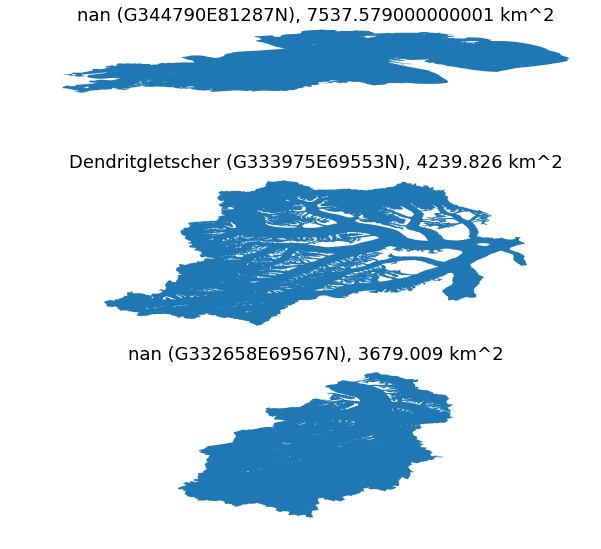

In [89]:
# Plot the 3 largest RGI for Region 5
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r5_rgi_largest_pd_1.plot(ax=ax1)
ax1.set_title(str(r5_rgi_largest_name_1['Name'][0]) + ' (' + r5_rgi_largest_name_1['GLIMSId'][0]
              + '), ' + str(r5_rgi_largest_name_1['Area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r5_rgi_largest_pd_2.plot(ax=ax2)
ax2.set_title(str(r5_rgi_largest_name_2['Name'][1]) + ' (' + r5_rgi_largest_name_2['GLIMSId'][1]
              + '), ' + str(r5_rgi_largest_name_2['Area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot third largest glacier
r5_rgi_largest_pd_3.plot(ax=ax3)
ax3.set_title(str(r5_rgi_largest_name_3['Name'][2]) + ' (' + r5_rgi_largest_name_3['GLIMSId'][2]
              + '), ' + str(r5_rgi_largest_name_3['Area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

In [90]:
# Save 3 largest from RGI for Region 5 to shapefile
ws.save_3_largest(r5_rgi_largest_pd_1, r5_rgi_largest_pd_2, r5_rgi_largest_pd_3, 5, 'RGI')

##### Comparison Analysis

In [91]:
# Print GLIMS Region 5 csv file with 10 largest glaciers
ws.print_10_largest_glims(5)
print('')

GLIMS 10 Largest glaciers and their size for Region 5 - Greenland Periphery:

      Glacier ID               Area (km^2)      Glacier Name       Date of Measurement
      G344790E81287N              7537.75                 None  2003-07-01T00:00:00
      G329763E69208N              5793.78     CHRISTIAN IV GL.  1995-12-16T00:00:00
      G329389E69966N              5169.31        VESTFJORD GL.  1995-12-16T00:00:00
      G333975E69553N              4241.04                 None  2000-08-28T00:00:00
      G332658E69567N              3682.25                 None  2000-08-28T00:00:00
      G330976E68786N              2979.31                 None  1999-08-01T00:00:00
      G331685E69750N              2430.62                 None  2001-09-21T00:00:00
      G330143E70706N              2429.39           ROLIGE BR  1995-12-16T00:00:00
      G331717E69556N              2414.99                 None  1995-12-16T00:00:00
      G331157E69166N              2262.67                 None  1999-08-01T00:0

In [92]:
# Print RGI Region 5 csv file with 10 largest glaciers
ws.print_10_largest_rgi(5)
print('')

RGI 10 Largest glaciers and their size for Region 5 - Greenland Periphery:

      Glacier ID               Area (km^2)      Glacier Name       Date of Measurement
      G344790E81287N             7537.579                  NaN             20010703
      G333975E69553N             4239.826     Dendritgletscher             20000828
      G332658E69567N             3679.009                  NaN             20010712
      G330976E68786N             2975.915                  NaN             19990811
      G331685E69750N             2428.633                  NaN             20010921
      G331157E69166N             2219.510           Borggraven             19990811
      G332759E68980N             1235.267            Sortebrae             19990811
      G334864E70010N             1225.471                  NaN             20000828
      G327559E68005N             1146.469                  NaN             20020814
      G335358E69815N             1024.530                  NaN             200008

In [94]:
# Plot all 3 together on a natural earth basemap
# Set up legend
legend_colors = ['darkorange', 'lime', 'red']
legend_labels = ['Flade Isblink Ice Cap',
                 r5_glims_largest_name_2['glac_name'][1], r5_glims_largest_name_3['glac_name'][2]]
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = glacier_regions.loc[4:4].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 1
es.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest and the title and legend
r5_glims_largest_pd_1.plot(ax=ax, color="darkorange")
r5_glims_largest_pd_2.plot(ax=ax, color="lime")
r5_glims_largest_pd_3.plot(ax=ax, color="red")
ax.set_title('3 Largest Glaciers for Region 5 - Greenland Periphery', fontsize=24)
ax.legend(handles=legend_patches,
          facecolor="white",
          edgecolor="white",
          bbox_to_anchor=(1.35, 1))
ax.set_axis_off()

##### Ice Cap Analysis

### Region 6 - Iceland

In [ ]:
# Open GLIMS region 6 shapefile
glims_region_6_fp = "data/glims/processed/cleaned/glims_region_6_cleaned.shp"
glims_polygons_r6 = gpd.read_file(glims_region_6_fp)

In [ ]:
# Open GLIMS Region 6 csv file with 10 largest glaciers
glims_largest_r6 = ws.print_10_largest_glims(6)

In [ ]:
# Open and print RGI Region 6 csv file with 10 largest glaciers
rgi_largest_r6 = ws.print_10_largest_rgi(6)

In [ ]:
# Select 3 largest from GLIMS Region 6
r6_largest_name_1 = glims_largest_r6.iloc[0:1]
r6_largest_pd_1 = glims_polygons_r6[glims_polygons_r6['glac_id']==r6_largest_name_1['glac_id'][0]]

r6_largest_name_2 = glims_largest_r6.iloc[1:2]
r6_largest_pd_2 = glims_polygons_r6[glims_polygons_r6['glac_id']==r6_largest_name_2['glac_id'][1]]

r6_largest_name_3 = glims_largest_r6.iloc[2:3]
r6_largest_pd_3 = glims_polygons_r6[glims_polygons_r6['glac_id']==r6_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r6_largest_pd_1.plot(ax=ax1)
ax1.set_title(r6_largest_name_1['glac_name'][0] + ' (' + r6_largest_name_1['glac_id']
              [0] + '), ' + str(r6_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r6_largest_pd_2.plot(ax=ax2)
ax2.set_title(r6_largest_name_2['glac_name'][1] + ' (' + r6_largest_name_2['glac_id']
              [1] + '), ' + str(r6_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r6_largest_pd_3.plot(ax=ax3)
ax3.set_title(r6_largest_name_3['glac_name'][2] + ' (' + r6_largest_name_3['glac_id']
              [2] + '), ' + str(r6_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 7 - Svalbard and Jan Mayen

In [ ]:
# Open GLIMS region 7 shapefile
glims_region_7_fp = "data/glims/processed/cleaned/glims_region_7_cleaned.shp"
glims_polygons_r7 = gpd.read_file(glims_region_7_fp)

In [ ]:
# Open GLIMS Region 7 csv file with 10 largest glaciers
glims_largest_r7 = ws.print_10_largest_glims(7)

In [ ]:
# Open and print RGI Region 7 csv file with 10 largest glaciers
rgi_largest_r7 = ws.print_10_largest_rgi(7)

In [ ]:
# Select 3 largest from GLIMS Region 7
r7_largest_name_1 = glims_largest_r7.iloc[0:1]
r7_largest_pd_1 = glims_polygons_r7[glims_polygons_r7['glac_id']==r7_largest_name_1['glac_id'][0]]

r7_largest_name_2 = glims_largest_r7.iloc[1:2]
r7_largest_pd_2 = glims_polygons_r7[glims_polygons_r7['glac_id']==r7_largest_name_2['glac_id'][1]]

r7_largest_name_3 = glims_largest_r7.iloc[2:3]
r7_largest_pd_3 = glims_polygons_r7[glims_polygons_r7['glac_id']==r7_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r7_largest_pd_1.plot(ax=ax1)
ax1.set_title(r7_largest_name_1['glac_name'][0] + ' (' + r7_largest_name_1['glac_id']
              [0] + '), ' + str(r7_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r7_largest_pd_2.plot(ax=ax2)
ax2.set_title(r7_largest_name_2['glac_name'][1] + ' (' + r7_largest_name_2['glac_id']
              [1] + '), ' + str(r7_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r7_largest_pd_3.plot(ax=ax3)
ax3.set_title(r7_largest_name_3['glac_name'][2] + ' (' + r7_largest_name_3['glac_id']
              [2] + '), ' + str(r7_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 8 - Scandinavia

In [ ]:
# Open GLIMS region 8 shapefile
glims_region_8_fp = "data/glims/processed/cleaned/glims_region_8_cleaned.shp"
glims_polygons_r8 = gpd.read_file(glims_region_8_fp)

In [ ]:
# Open GLIMS Region 8 csv file with 10 largest glaciers
glims_largest_r8 = ws.print_10_largest_glims(8)

In [ ]:
# Open and print RGI Region 8 csv file with 10 largest glaciers
rgi_largest_r8 = ws.print_10_largest_rgi(8)

In [ ]:
# Select 3 largest from GLIMS Region 8
r8_largest_name_1 = glims_largest_r8.iloc[0:1]
r8_largest_pd_1 = glims_polygons_r8[glims_polygons_r8['glac_id']==r8_largest_name_1['glac_id'][0]]

r8_largest_name_2 = glims_largest_r8.iloc[1:2]
r8_largest_pd_2 = glims_polygons_r8[glims_polygons_r8['glac_id']==r8_largest_name_2['glac_id'][1]]

r8_largest_name_3 = glims_largest_r8.iloc[2:3]
r8_largest_pd_3 = glims_polygons_r8[glims_polygons_r8['glac_id']==r8_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r8_largest_pd_1.plot(ax=ax1)
ax1.set_title(r8_largest_name_1['glac_name'][0] + ' (' + r8_largest_name_1['glac_id']
              [0] + '), ' + str(r8_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r8_largest_pd_2.plot(ax=ax2)
ax2.set_title(r8_largest_name_2['glac_name'][1] + ' (' + r8_largest_name_2['glac_id']
              [1] + '), ' + str(r8_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r8_largest_pd_3.plot(ax=ax3)
ax3.set_title(r8_largest_name_3['glac_name'][2] + ' (' + r8_largest_name_3['glac_id']
              [2] + '), ' + str(r8_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 9 - Russian Arctic

In [ ]:
# Open GLIMS region 9 shapefile
glims_region_9_fp = "data/glims/processed/cleaned/glims_region_9_cleaned.shp"
glims_polygons_r9 = gpd.read_file(glims_region_9_fp)

In [ ]:
# Open GLIMS Region 9 csv file with 10 largest glaciers
glims_largest_r9 = ws.print_10_largest_glims(9)

In [ ]:
# Open and print RGI Region 9 csv file with 10 largest glaciers
rgi_largest_r9 = ws.print_10_largest_rgi(9)

In [ ]:
# Select 3 largest from GLIMS Region 9
r9_largest_name_1 = glims_largest_r9.iloc[0:1]
r9_largest_pd_1 = glims_polygons_r9[glims_polygons_r9['glac_id']==r9_largest_name_1['glac_id'][0]]

r9_largest_name_2 = glims_largest_r9.iloc[1:2]
r9_largest_pd_2 = glims_polygons_r9[glims_polygons_r9['glac_id']==r9_largest_name_2['glac_id'][1]]

r9_largest_name_3 = glims_largest_r9.iloc[2:3]
r9_largest_pd_3 = glims_polygons_r9[glims_polygons_r9['glac_id']==r9_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r9_largest_pd_1.plot(ax=ax1)
ax1.set_title(r9_largest_name_1['glac_name'][0] + ' (' + r9_largest_name_1['glac_id']
              [0] + '), ' + str(r9_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r9_largest_pd_2.plot(ax=ax2)
ax2.set_title(r9_largest_name_2['glac_name'][1] + ' (' + r9_largest_name_2['glac_id']
              [1] + '), ' + str(r9_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r9_largest_pd_3.plot(ax=ax3)
ax3.set_title(r9_largest_name_3['glac_name'][2] + ' (' + r9_largest_name_3['glac_id']
              [2] + '), ' + str(r9_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 10 - Asia, North

In [ ]:
# Open GLIMS region 10 shapefile
glims_region_10_fp = "data/glims/processed/cleaned/glims_region_10_cleaned.shp"
glims_polygons_r10 = gpd.read_file(glims_region_10_fp)

In [ ]:
# Open GLIMS Region 10 csv file with 10 largest glaciers
glims_largest_r10 = ws.print_10_largest_glims(10)

In [ ]:
# Open and print RGI Region 10 csv file with 10 largest glaciers
rgi_largest_r10 = ws.print_10_largest_rgi(10)

In [ ]:
# Select 3 largest from GLIMS Region 10
r10_largest_name_1 = glims_largest_r10.iloc[0:1]
r10_largest_pd_1 = glims_polygons_r10[glims_polygons_r10['glac_id']==r10_largest_name_1['glac_id'][0]]

r10_largest_name_2 = glims_largest_r10.iloc[1:2]
r10_largest_pd_2 = glims_polygons_r10[glims_polygons_r10['glac_id']==r10_largest_name_2['glac_id'][1]]

r10_largest_name_3 = glims_largest_r10.iloc[2:3]
r10_largest_pd_3 = glims_polygons_r10[glims_polygons_r10['glac_id']==r10_largest_name_3['glac_id'][2]]

In [ ]:
r10_largest_pd_1

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r10_largest_pd_1.plot(ax=ax1)
ax1.set_title(r10_largest_name_1['glac_name'][0] + ' (' + r10_largest_name_1['glac_id']
              [0] + '), ' + str(r10_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)

# Plot second largest glacier
r10_largest_pd_2.plot(ax=ax2)
ax2.set_title(r10_largest_name_2['glac_name'][1] + ' (' + r10_largest_name_2['glac_id']
              [1] + '), ' + str(r10_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r10_largest_pd_3.plot(ax=ax3)
ax3.set_title(r10_largest_name_3['glac_name'][2] + ' (' + r10_largest_name_3['glac_id']
              [2] + '), ' + str(r10_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 11 - Central Europe

In [ ]:
# Open GLIMS region 11 shapefile
glims_region_11_fp = "data/glims/processed/cleaned/glims_region_11_cleaned.shp"
glims_polygons_r11 = gpd.read_file(glims_region_11_fp)

In [ ]:
# Open GLIMS Region 11 csv file with 10 largest glaciers
glims_largest_r11 = ws.print_10_largest_glims(11)

In [ ]:
# Open and print RGI Region 11 csv file with 10 largest glaciers
rgi_largest_r11 = ws.print_10_largest_rgi(11)

In [ ]:
# Select 3 largest from GLIMS Region 11
r11_largest_name_1 = glims_largest_r11.iloc[0:1]
r11_largest_pd_1 = glims_polygons_r11[glims_polygons_r11['glac_id']==r11_largest_name_1['glac_id'][0]]

r11_largest_name_2 = glims_largest_r11.iloc[1:2]
r11_largest_pd_2 = glims_polygons_r11[glims_polygons_r11['glac_id']==r11_largest_name_2['glac_id'][1]]

r11_largest_name_3 = glims_largest_r11.iloc[2:3]
r11_largest_pd_3 = glims_polygons_r11[glims_polygons_r11['glac_id']==r11_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r11_largest_pd_1.plot(ax=ax1)
ax1.set_title(r11_largest_name_1['glac_name'][0] + ' (' + r11_largest_name_1['glac_id']
              [0] + '), ' + str(r11_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r11_largest_pd_2.plot(ax=ax2)
ax2.set_title(r11_largest_name_2['glac_name'][1] + ' (' + r11_largest_name_2['glac_id']
              [1] + '), ' + str(r11_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r11_largest_pd_3.plot(ax=ax3)
ax3.set_title(r11_largest_name_3['glac_name'][2] + ' (' + r1_largest_name_3['glac_id']
              [2] + '), ' + str(r11_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 12 - Caucasus and Middle East

In [ ]:
# Open GLIMS region 12 shapefile
glims_region_12_fp = "data/glims/processed/cleaned/glims_region_12_cleaned.shp"
glims_polygons_r12 = gpd.read_file(glims_region_12_fp)

In [ ]:
# Open GLIMS Region 12 csv file with 10 largest glaciers
glims_largest_r12 = ws.print_10_largest_glims(12)

In [ ]:
# Open and print RGI Region 12 csv file with 10 largest glaciers
rgi_largest_r12 = ws.print_10_largest_rgi(12)

In [ ]:
# Select 3 largest from GLIMS Region 12
r12_largest_name_1 = glims_largest_r12.iloc[0:1]
r12_largest_pd_1 = glims_polygons_r12[glims_polygons_r12['glac_id']==r12_largest_name_1['glac_id'][0]]

r12_largest_name_2 = glims_largest_r12.iloc[1:2]
r12_largest_pd_2 = glims_polygons_r12[glims_polygons_r12['glac_id']==r12_largest_name_2['glac_id'][1]]

r12_largest_name_3 = glims_largest_r12.iloc[2:3]
r12_largest_pd_3 = glims_polygons_r12[glims_polygons_r12['glac_id']==r12_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r12_largest_pd_1.plot(ax=ax1)
ax1.set_title(r12_largest_name_1['glac_name'][0] + ' (' + r12_largest_name_1['glac_id']
              [0] + '), ' + str(r12_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r12_largest_pd_2.plot(ax=ax2)
ax2.set_title(r12_largest_name_2['glac_name'][1] + ' (' + r12_largest_name_2['glac_id']
              [1] + '), ' + str(r12_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r12_largest_pd_3.plot(ax=ax3)
ax3.set_title(r12_largest_name_3['glac_name'][2] + ' (' + r12_largest_name_3['glac_id']
              [2] + '), ' + str(r12_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 13 - Asia, Central

In [ ]:
# Open GLIMS region 13 shapefile
glims_region_13_fp = "data/glims/processed/cleaned/glims_region_13_cleaned.shp"
glims_polygons_r13 = gpd.read_file(glims_region_13_fp)

In [ ]:
# Open GLIMS Region 13 csv file with 10 largest glaciers
glims_largest_r13 = ws.print_10_largest_glims(13)

In [ ]:
# Open and print RGI Region 13 csv file with 10 largest glaciers
rgi_largest_r13 = ws.print_10_largest_rgi(13)

In [ ]:
# Select 3 largest from GLIMS Region 13
r13_largest_name_1 = glims_largest_r13.iloc[0:1]
r13_largest_pd_1 = glims_polygons_r13[glims_polygons_r13['glac_id']==r13_largest_name_1['glac_id'][0]]

r13_largest_name_2 = glims_largest_r13.iloc[1:2]
r13_largest_pd_2 = glims_polygons_r13[glims_polygons_r13['glac_id']==r13_largest_name_2['glac_id'][1]]

r13_largest_name_3 = glims_largest_r13.iloc[2:3]
r13_largest_pd_3 = glims_polygons_r13[glims_polygons_r13['glac_id']==r13_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r13_largest_pd_1.plot(ax=ax1)
ax1.set_title(r13_largest_name_1['glac_name'][0] + ' (' + r13_largest_name_1['glac_id']
              [0] + '), ' + str(r13_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r13_largest_pd_2.plot(ax=ax2)
ax2.set_title(r13_largest_name_2['glac_name'][1] + ' (' + r13_largest_name_2['glac_id']
              [1] + '), ' + str(r13_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r13_largest_pd_3.plot(ax=ax3)
ax3.set_title(r13_largest_name_3['glac_name'][2] + ' (' + r13_largest_name_3['glac_id']
              [2] + '), ' + str(r13_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 14 - Asia, South West

In [ ]:
# Open GLIMS region 14 shapefile
glims_region_14_fp = "data/glims/processed/cleaned/glims_region_14_cleaned.shp"
glims_polygons_r14 = gpd.read_file(glims_region_14_fp)

In [ ]:
# Open GLIMS Region 14 csv file with 10 largest glaciers
glims_largest_r14 = ws.print_10_largest_glims(14)

In [ ]:
# Open and print RGI Region 14 csv file with 10 largest glaciers
rgi_largest_r14 = ws.print_10_largest_rgi(14)

In [ ]:
# Select 3 largest from GLIMS Region 14
r14_largest_name_1 = glims_largest_r14.iloc[0:1]
r14_largest_pd_1 = glims_polygons_r14[glims_polygons_r14['glac_id']==r14_largest_name_1['glac_id'][0]]

r14_largest_name_2 = glims_largest_r14.iloc[1:2]
r14_largest_pd_2 = glims_polygons_r14[glims_polygons_r14['glac_id']==r14_largest_name_2['glac_id'][1]]

r14_largest_name_3 = glims_largest_r14.iloc[2:3]
r14_largest_pd_3 = glims_polygons_r14[glims_polygons_r14['glac_id']==r14_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r14_largest_pd_1.plot(ax=ax1)
ax1.set_title(r14_largest_name_1['glac_name'][0] + ' (' + r14_largest_name_1['glac_id']
              [0] + '), ' + str(r14_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r14_largest_pd_2.plot(ax=ax2)
ax2.set_title(r14_largest_name_2['glac_name'][1] + ' (' + r14_largest_name_2['glac_id']
              [1] + '), ' + str(r14_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r14_largest_pd_3.plot(ax=ax3)
ax3.set_title(r14_largest_name_3['glac_name'][2] + ' (' + r14_largest_name_3['glac_id']
              [2] + '), ' + str(r14_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 15 - Asia, South East

In [ ]:
# Open GLIMS region 15 shapefile
glims_region_15_fp = "data/glims/processed/cleaned/glims_region_15_cleaned.shp"
glims_polygons_r15 = gpd.read_file(glims_region_15_fp)

In [ ]:
# Open GLIMS Region 15 csv file with 10 largest glaciers
glims_largest_r15 = ws.print_10_largest_glims(15)

In [ ]:
# Open and print RGI Region 15 csv file with 10 largest glaciers
rgi_largest_r15 = ws.print_10_largest_rgi(15)

In [ ]:
# Select 3 largest from GLIMS Region 15
r15_largest_name_1 = glims_largest_r15.iloc[0:1]
r15_largest_pd_1 = glims_polygons_r15[glims_polygons_r15['glac_id']==r15_largest_name_1['glac_id'][0]]

r15_largest_name_2 = glims_largest_r15.iloc[1:2]
r15_largest_pd_2 = glims_polygons_r15[glims_polygons_r15['glac_id']==r15_largest_name_2['glac_id'][1]]

r15_largest_name_3 = glims_largest_r15.iloc[2:3]
r15_largest_pd_3 = glims_polygons_r15[glims_polygons_r15['glac_id']==r15_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r15_largest_pd_1.plot(ax=ax1)
ax1.set_title(r15_largest_name_1['glac_name'][0] + ' (' + r15_largest_name_1['glac_id']
              [0] + '), ' + str(r15_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r15_largest_pd_2.plot(ax=ax2)
ax2.set_title(r15_largest_name_2['glac_name'][1] + ' (' + r15_largest_name_2['glac_id']
              [1] + '), ' + str(r15_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r15_largest_pd_3.plot(ax=ax3)
ax3.set_title(r15_largest_name_3['glac_name'][2] + ' (' + r15_largest_name_3['glac_id']
              [2] + '), ' + str(r15_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 16 - Low Latitudes

In [ ]:
# Open GLIMS region 16 shapefile
glims_region_16_fp = "data/glims/processed/cleaned/glims_region_16_cleaned.shp"
glims_polygons_r16 = gpd.read_file(glims_region_16_fp)

In [ ]:
# Open GLIMS Region 16 csv file with 10 largest glaciers
glims_largest_r16 = ws.print_10_largest_glims(16)

In [ ]:
# Open and print RGI Region 16 csv file with 10 largest glaciers
rgi_largest_r16 = ws.print_10_largest_rgi(16)

In [ ]:
# Select 3 largest from GLIMS Region 16
r16_largest_name_1 = glims_largest_r16.iloc[0:1]
r16_largest_pd_1 = glims_polygons_r16[glims_polygons_r16['glac_id']==r16_largest_name_1['glac_id'][0]]

r16_largest_name_2 = glims_largest_r16.iloc[1:2]
r16_largest_pd_2 = glims_polygons_r16[glims_polygons_r16['glac_id']==r16_largest_name_2['glac_id'][1]]

r16_largest_name_3 = glims_largest_r16.iloc[2:3]
r16_largest_pd_3 = glims_polygons_r16[glims_polygons_r16['glac_id']==r16_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r16_largest_pd_1.plot(ax=ax1)
ax1.set_title(r16_largest_name_1['glac_name'][0] + ' (' + r16_largest_name_1['glac_id']
              [0] + '), ' + str(r16_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r16_largest_pd_2.plot(ax=ax2)
ax2.set_title(r16_largest_name_2['glac_name'][1] + ' (' + r16_largest_name_2['glac_id']
              [1] + '), ' + str(r16_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r16_largest_pd_3.plot(ax=ax3)
ax3.set_title(r16_largest_name_3['glac_name'][2] + ' (' + r16_largest_name_3['glac_id']
              [2] + '), ' + str(r16_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 17 - Southern Andes

In [ ]:
# Open GLIMS region 17 shapefile
glims_region_17_fp = "data/glims/processed/cleaned/glims_region_17_cleaned.shp"
glims_polygons_r17 = gpd.read_file(glims_region_17_fp)

In [ ]:
# Open GLIMS Region 17 csv file with 10 largest glaciers
glims_largest_r17 = ws.print_10_largest_glims(17)

In [ ]:
# Open and print RGI Region 17 csv file with 10 largest glaciers
rgi_largest_r17 = ws.print_10_largest_rgi(17)

In [ ]:
# Select 3 largest from GLIMS Region 17
r17_largest_name_1 = glims_largest_r17.iloc[0:1]
r17_largest_pd_1 = glims_polygons_r17[glims_polygons_r17['glac_id']==r17_largest_name_1['glac_id'][0]]

r17_largest_name_2 = glims_largest_r17.iloc[1:2]
r17_largest_pd_2 = glims_polygons_r17[glims_polygons_r17['glac_id']==r17_largest_name_2['glac_id'][1]]

r17_largest_name_3 = glims_largest_r17.iloc[2:3]
r17_largest_pd_3 = glims_polygons_r17[glims_polygons_r17['glac_id']==r17_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r17_largest_pd_1.plot(ax=ax1)
ax1.set_title(r17_largest_name_1['glac_name'][0] + ' (' + r17_largest_name_1['glac_id']
              [0] + '), ' + str(r17_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r17_largest_pd_2.plot(ax=ax2)
ax2.set_title(r17_largest_name_2['glac_name'][1] + ' (' + r17_largest_name_2['glac_id']
              [1] + '), ' + str(r17_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r17_largest_pd_3.plot(ax=ax3)
ax3.set_title(r17_largest_name_3['glac_name'][2] + ' (' + r17_largest_name_3['glac_id']
              [2] + '), ' + str(r17_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 18 - New Zealand

In [ ]:
# Open GLIMS region 18 shapefile
glims_region_18_fp = "data/glims/processed/cleaned/glims_region_18_cleaned.shp"
glims_polygons_r18 = gpd.read_file(glims_region_18_fp)

In [ ]:
# Open GLIMS Region 18 csv file with 10 largest glaciers
glims_largest_r18 = ws.print_10_largest_glims(18)

In [ ]:
# Open and print RGI Region 18 csv file with 10 largest glaciers
rgi_largest_r18 = ws.print_10_largest_rgi(18)

In [ ]:
# Select 3 largest from GLIMS Region 18
r18_largest_name_1 = glims_largest_r18.iloc[0:1]
r18_largest_pd_1 = glims_polygons_r18[glims_polygons_r18['glac_id']==r18_largest_name_1['glac_id'][0]]

r18_largest_name_2 = glims_largest_r18.iloc[1:2]
r18_largest_pd_2 = glims_polygons_r18[glims_polygons_r18['glac_id']==r18_largest_name_2['glac_id'][1]]

r18_largest_name_3 = glims_largest_r18.iloc[2:3]
r18_largest_pd_3 = glims_polygons_r18[glims_polygons_r18['glac_id']==r18_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r18_largest_pd_1.plot(ax=ax1)
ax1.set_title(r18_largest_name_1['glac_name'][0] + ' (' + r18_largest_name_1['glac_id']
              [0] + '), ' + str(r18_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r18_largest_pd_2.plot(ax=ax2)
ax2.set_title(r18_largest_name_2['glac_name'][1] + ' (' + r18_largest_name_2['glac_id']
              [1] + '), ' + str(r18_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r18_largest_pd_3.plot(ax=ax3)
ax3.set_title(r18_largest_name_3['glac_name'][2] + ' (' + r18_largest_name_3['glac_id']
              [2] + '), ' + str(r18_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

### Region 19 - Antarctic and Subantarctic

In [ ]:
# Open GLIMS region 19 shapefile
glims_region_19_fp = "data/glims/processed/cleaned/glims_region_19_cleaned.shp"
glims_polygons_r19 = gpd.read_file(glims_region_19_fp)

In [ ]:
# Open GLIMS Region 19 csv file with 10 largest glaciers
glims_largest_r19 = ws.print_10_largest_glims(19)

In [ ]:
# Open and print RGI Region 19 csv file with 10 largest glaciers
rgi_largest_r19 = ws.print_10_largest_rgi(19)

In [ ]:
# Select 3 largest from GLIMS Region 19
r19_largest_name_1 = glims_largest_r19.iloc[0:1]
r19_largest_pd_1 = glims_polygons_r19[glims_polygons_r19['glac_id']==r19_largest_name_1['glac_id'][0]]

r19_largest_name_2 = glims_largest_r19.iloc[1:2]
r19_largest_pd_2 = glims_polygons_r19[glims_polygons_r19['glac_id']==r19_largest_name_2['glac_id'][1]]

r19_largest_name_3 = glims_largest_r19.iloc[2:3]
r19_largest_pd_3 = glims_polygons_r19[glims_polygons_r19['glac_id']==r19_largest_name_3['glac_id'][2]]

In [ ]:
# Plot the 3 largest
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot largest glacier
r19_largest_pd_1.plot(ax=ax1)
ax1.set_title(r19_largest_name_1['glac_name'][0] + ' (' + r19_largest_name_1['glac_id']
              [0] + '), ' + str(r19_largest_name_1['db_area'][0]) + ' km^2', fontsize=18)
ax1.set_axis_off()

# Plot second largest glacier
r19_largest_pd_2.plot(ax=ax2)
ax2.set_title(r19_largest_name_2['glac_name'][1] + ' (' + r19_largest_name_2['glac_id']
              [1] + '), ' + str(r19_largest_name_2['db_area'][1]) + ' km^2', fontsize=18)
ax2.set_axis_off()

# Plot second largest glacier
r19_largest_pd_3.plot(ax=ax3)
ax3.set_title(r19_largest_name_3['glac_name'][2] + ' (' + r19_largest_name_3['glac_id']
              [2] + '), ' + str(r19_largest_name_3['db_area'][2]) + ' km^2', fontsize=18)
ax3.set_axis_off()

## Global Analysis

This section combines all of the data from GLIMS and RGI and lists which are the 3 biggest glaciers in the world.

### GLIMS

In [ ]:
# Concatenate 10 largest from GLIMS for all regions
all_glims = pd.concat([glims_largest_r1, glims_largest_r2, glims_largest_r3, 
                       glims_largest_r4, glims_largest_r5, glims_largest_r6, 
                       glims_largest_r7, glims_largest_r8, glims_largest_r9,
                       glims_largest_r10, glims_largest_r11, glims_largest_r12,
                       glims_largest_r13, glims_largest_r14, glims_largest_r15,
                       glims_largest_r16, glims_largest_r17, glims_largest_r18, glims_largest_r19])
# Reset index
all_glims.reset_index(inplace=True)

In [ ]:
# Largest glacier in the world according to GLIMS
# TBD need to add region to csv file or to the pandas data frame
all_glims.loc[all_glims['db_area'].idxmax()]

In [ ]:
# Top 3 in the world according to GLIMS
all_glims.nlargest(3, 'db_area')

The 3 GLIMS glaciers listed above with their regions:
* Vatnajokull Glacier in Region 6 - Iceland (Area 8091.67 km^2)
* Glacier with unknown name in Region 5 - Greenland (Area 7537.75 km^2) (TBD - try and determine the name)
* Seller Glacier in Region 19 - Antarctic and Subantarctic (Area 7018.32 km^2)

### RGI

In [ ]:
# Concatenate 10 largest from RGI for all regions
all_rgi = pd.concat([rgi_largest_r1, rgi_largest_r2, rgi_largest_r3, 
                       rgi_largest_r4, rgi_largest_r5, rgi_largest_r6, 
                       rgi_largest_r7, rgi_largest_r8, rgi_largest_r9,
                       rgi_largest_r10, rgi_largest_r11, rgi_largest_r12,
                       rgi_largest_r13, rgi_largest_r14, rgi_largest_r15,
                       rgi_largest_r16, rgi_largest_r17, rgi_largest_r18, glims_largest_r19], sort=True)
# Reset index
all_rgi.reset_index(inplace=True)

In [ ]:
# Largest glacier in the world according to RGI
# TBD need to add region to csv file or to the pandas data frame
all_rgi.loc[all_rgi['Area'].idxmax()]

In [ ]:
# Top 3 in the world according to RGI
all_rgi.nlargest(3, 'Area')

The 3 RGI glaciers listed above with their regions:
* Glacier with unknown name in Region 5 - Greenland (Area 7537.58 km^2) (TBD try and determine the name)
* Dendritgletscher in Region 5 - Greenland (Area 4239.83 km^2)
* Glacier with unknown name in Region 5 - Greenland (Area 3679.01 km^2) (TBD try and determine the name)

# Conclusion/Summary

This preliminary analysis shows plots of the 3 largest glaciers for each of the 19 glacier regions based on the GLIMS database. Work still needs to be done to compare the 3 largest from the RGI database and compare them. There are some issues with the GLIMS database that need to be cleared up. They are the following:
* For region 10, the plot of the largest glacier, Toll Ice Cap, does not look correct since it is just an oval. Also, need to define what I mean by glacier. That is, should ice caps be included at all.
* For region 15, Yanong Glacier is listed as the both the largest and second largest. Need to investigate why that is occurring.
* For region 3 (and some others), the glacier name is "None" in the GLIMS database but these glaciers do have names in the RGI database. Will want to cross-compare to determine the names of the glaciers and possible suggest improvements to the GLIMS team and CU Boulder for the GLIMS database.

Other work yet to be completed is to find the largest glacier out of all of these to determine the largest glacier in the world. From a manual inspection of the glaciers listed above, Vatnajokull Glacier in Region 6 - Iceland at 8091.67 km^2 is the largest. Now need to see if the RGI agrees and also do some literature research to determine if the values from GLIMS and RGI are accurate. Then a full report and an education and outreach web page needs to be created.

In [ ]:
# Save the 3 largest from each region to its own shapefile
#shapefile_list = [r1_largest_pd_1, r1_largest_pd_2, r1_largest_pd_3, r2_largest_pd_1, r2_largest_pd_2, r2_largest_pd_3,
#                  r3_largest_pd_1, r3_largest_pd_2, r3_largest_pd_3, r4_largest_pd_1, r4_largest_pd_2, r4_largest_pd_3,
#                  r5_largest_pd_1, r5_largest_pd_2, r5_largest_pd_3, r6_largest_pd_1, r6_largest_pd_2, r6_largest_pd_3,
#                  r7_largest_pd_1, r7_largest_pd_2, r7_largest_pd_3, r8_largest_pd_1, r8_largest_pd_2, r8_largest_pd_3,
#                  r9_largest_pd_1, r9_largest_pd_2, r9_largest_pd_3, r10_largest_pd_1, r10_largest_pd_2, r10_largest_pd_3,
#                  r11_largest_pd_1, r11_largest_pd_2, r11_largest_pd_3, r12_largest_pd_1, r12_largest_pd_2, r12_largest_pd_3,
#                  r13_largest_pd_1, r13_largest_pd_2, r13_largest_pd_3, r14_largest_pd_1, r14_largest_pd_2, r14_largest_pd_3,
#                  r15_largest_pd_1, r15_largest_pd_2, r15_largest_pd_3, r16_largest_pd_1, r16_largest_pd_2, r16_largest_pd_3,
#                  r17_largest_pd_1, r17_largest_pd_2, r17_largest_pd_3, r18_largest_pd_1, r18_largest_pd_2, r18_largest_pd_3,
#                  r19_largest_pd_1, r19_largest_pd_2, r19_largest_pd_3]
#counter = 0
#for x in range(0,19):
#    print("region:", x+1)
#    ws.save_3_largest(shapefile_list[counter], shapefile_list[counter+1], shapefile_list[counter+2], x+1)
#    counter = counter + 3